In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from netCDF4 import Dataset
%matplotlib inline
# %matplotlib qt
# %matplotlib osx
import numpy as np
import cmocean
import itertools
from mpl_toolkits.basemap import Basemap
import numpy as np
from scipy import interpolate
import statsmodels.api as sm
from adjustText import adjust_text

sns.set_style("whitegrid")
sns.set_style("ticks")
from datetime import datetime
str(datetime.now())

# sns.set_palette('colorblind')


/Users/imarkelo/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/Users/imarkelo/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


'2018-10-26 00:04:51.818792'

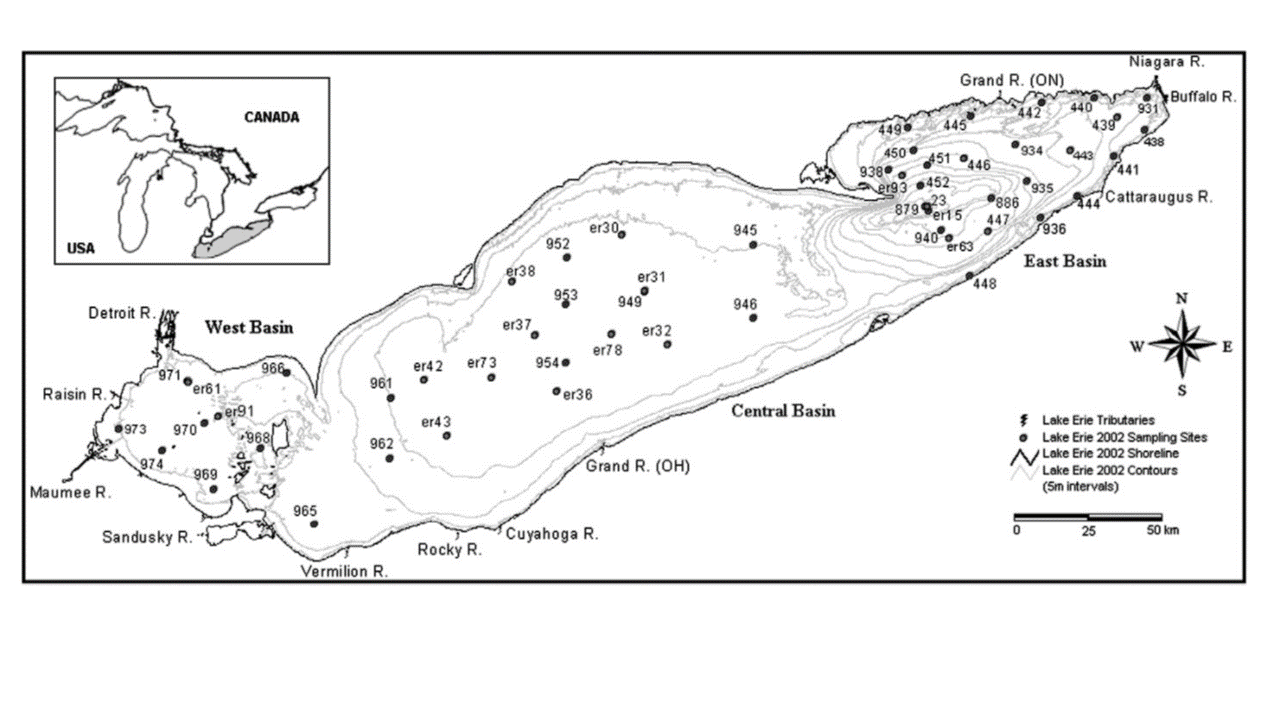

In [2]:
from IPython.display import Image
Image(filename='/Users/imarkelo/git/Great-Lakes-Data/measurements/ECCC/Lake_Erie_map_with_stations-1.png') 

In [3]:
df = pd.read_excel('../../measurements/ECCC/LakeErie_Markelov_Dove26May2017.xlsx', sheetname='Data')
ECCCmeas = df[df['DEPTH_TO']==0]
ECCCmeas['YEAR']=pd.to_datetime(pd.DatetimeIndex(ECCCmeas['STN_DATE'])).year
ECCCmeas['MONTH']=pd.to_datetime(pd.DatetimeIndex(ECCCmeas['STN_DATE'])).month
ECCCmeas = ECCCmeas[ECCCmeas['YEAR']>1999]
# Cl = Cl[Cl.QC_TYPE=='routine field sample']
# Cl = Cl[~Cl.DEPTH_CODE.isin(['Integrated, Spring', 'Integrated, Summer'])]
# Cl = Cl[Cl.YEAR>2002]
# Cl.loc[:,'SAMPLE_DEPTH_M'] *= -1

/Users/imarkelo/anaconda3/lib/python3.6/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)
/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [4]:
eastern_basin_a = [448, 940, 879, 938, 450, 449, 451, 452, 447, 936,886,446, 445,934,935,444,441,443,442,440,439,438,931]
central_basin_a = [965, 962, 961, 954, 953, 952, 949, 945, 946]
western_basin_a = [971, 973, 974, 970, 966, 968, 969]

In [5]:
eastern_basin_b = [937,939,941,942,887,1237,1236,933,727,932, 486, 67]
central_basin_b = [493,492,491,338,885,311,339,341,963,964,960,859,918,919,957,958,1326,880,920,956,955,899,915,889,888,916,951,950,896,897,898,1053,948,947,1223,1222,1221,1220,1219,1218,1217,1216,1215,1214,1213,1212,1211,1210,1209,1292,943,944,947,205,1048]
western_basin_b = [882, 733, 881, 1156, 972, 343, 357, 358, 344, 337, 967, 494, 495, 496]


In [6]:
western_basin_f = list(filter(lambda x: x in  western_basin_a + western_basin_b, ECCCmeas.groupby(['PSN']).count().sort_values('CRUISE_PLAN', ascending=False).index))
central_basin_f = list(filter(lambda x: x in  central_basin_a + central_basin_b, ECCCmeas.groupby(['PSN']).count().sort_values('CRUISE_PLAN', ascending=False).index))
eastern_basin_f = list(filter(lambda x: x in  eastern_basin_a + eastern_basin_b, ECCCmeas.groupby(['PSN']).count().sort_values('CRUISE_PLAN', ascending=False).index))


In [7]:
western_basin_f[:6]

[970, 881, 969, 973, 967, 968]

In [8]:
spring = range(80, 172)
summer = range(172, 264)
fall = range(264, 355)

def season(x):
    if x in spring:
       return 'Spring'
    if x in summer:
       return 'Summer'
    if x in fall:
       return 'Fall'
    else:
       return 'Winter'

In [9]:
ECCCmeas['SEASON'] = pd.to_datetime(pd.DatetimeIndex(ECCCmeas['STN_DATE'])).dayofyear.map(season)

In [10]:
ECCCmeas.loc[:,'DEPTH_FROM'] *= -1

In [11]:
ECCCmeas = ECCCmeas[ECCCmeas['DEPTH_FROM']>-900]

In [12]:
ECCCmeas['VALUE'] = pd.to_numeric(ECCCmeas['VALUE'], errors='coerce')
ECCCmeas['PSN'] = pd.to_numeric(ECCCmeas['PSN'], errors='coerce')
ECCCmeas['LATITUDE_DD'] = pd.to_numeric(ECCCmeas['LATITUDE_DD'], errors='coerce')
ECCCmeas['LONGITUDE_DD'] = pd.to_numeric(ECCCmeas['LONGITUDE_DD'], errors='coerce')

In [13]:
stations = eastern_basin_f + central_basin_f + western_basin_f
years = range(2012,2016)
seasons = ['Spring', 'Summer']

In [14]:
ECCCmeas.ABBREV.unique()

array(['PH', 'D ORG C', 'POC', 'D 02 W', 'SAT 02', 'TP', 'SR P', 'TF P',
       'N TP', 'NH3', 'NO3NO2 F', 'S04 F', 'CL F', 'CA FA', 'MG F',
       'K-FAAS', 'NA-FAAS', 'D OXY P', 'CAU', 'CAC', 'AL/T-OES',
       'FE/T-OES', 'SO4', 'CL-F', 'AL/T-MS', 'FE/T-MS', 'D.I.C', 'F-F',
       'SO4-F', 'SRP-P-F', 'TP-P', 'TP-P-UF', 'TP-P-F', 'CA-F', 'K-F',
       'MG-F', 'NA-F'], dtype=object)

In [15]:
ECCCmeas.FULL_NAME.unique()

array(['PH', 'CARBON,DISSOLVED ORGANIC', 'CARBON,PARTICULATE ORGANIC',
       'OXYGEN,CONCENTRATION DISSOLVED', 'OXYGEN,% SAT. DISSOLVED',
       'PHOSPHOROUS,TOTAL', 'PHOSPHOROUS,SOLUBLE REACTIVE,FILTERED',
       'PHOSPHORUS,TOTAL FILTERED', 'NITROGEN,TOTAL PARTICULATE',
       'AMMONIA NITROGEN,SOLUBLE', 'NITRATE+NITRITE NITROGEN,FILTERED',
       'SULPHATE,FILTERED.', 'CHLORIDE,FILTERED',
       'CALCIUM,FILTERED ATOMIC ABS.', 'MAGNESIUM,FILTERED',
       'POTASSIUM-F.,ATOMIC ABSORPTION', 'SODIUM-F.,ATOMIC ABSORPTION',
       'DISSOLVED OXYGEN, PROFILER WQP', 'CHLOROPHYL A, UNCORRECTED',
       'CHLOROPHYLL A, CORRECTED PHAEOPHYTIN',
       'ALUMINUM                      ', 'IRON                          ',
       'SULPHATE', 'CHLORIDE', 'ALUMINUM', 'IRON',
       'DISSOLVED INORGANIC CARBON', 'FLUORIDE',
       'AMMONIA NITROGEN, SOLUBLE', 'NITRATE+NITRITE NITROGEN, FILTERED',
       'SOLUBLE REACTIVE PHOSPHOROUS', 'PHOSPHORUS, TOTAL, PARTICULATE',
       'TOTAL PHOSPHOROUS', 'TOT

In [16]:
# ECCCmeas = ECCCmeas[ECCCmeas['PSN'].isin(eastern_basin + central_basin + western_basin)]
ECCCmeas = ECCCmeas[ECCCmeas['SEASON'].isin(seasons)]
# ECCCmeas['VALUE'] = pd.to_numeric(ECCCmeas['VALUE'], errors='coerce')

In [17]:
ECCCmeas[~ECCCmeas['PSN'].isin(eastern_basin_f + central_basin_f + western_basin_f)].PSN.unique()

array([ 959,  980, 1163, 1238, 1239, 1240, 1257, 1207, 1262])

In [18]:
PSNs_loc = ECCCmeas.groupby(['PSN']).mean()[['LATITUDE_DD', 'LONGITUDE_DD']].reset_index()


In [19]:
nc = Dataset('../../measurements/bathymetry/erie_lld.grd')
topo = -nc.variables['z'][:] #[::10,::10]
x = nc.variables['x'][:] #[::10]
y = nc.variables['y'][:] #[::10]
lon, lat = np.meshgrid(x, y)

/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less_equal
  
/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [20]:
levels1 = np.linspace(0,70,14*2+1)

In [21]:
Cl = pd.read_csv('../../measurements/GLNPO/Mass Balance/Cl.csv')

In [22]:
GLENDA_stations = Cl.groupby(['STATION_ID']).mean()[['LATITUDE', 'LONGITUDE']].reset_index()

In [23]:
GLENDA_stations['LATITUDE'] = pd.to_numeric(GLENDA_stations['LATITUDE'], errors='coerce')
GLENDA_stations['LONGITUDE'] = pd.to_numeric(GLENDA_stations['LONGITUDE'], errors='coerce')

In [24]:
glenda_eastern_basin = ['ER15M', 'ER09', 'ER63', 'ER10']
glenda_central_basin = ['ER78M', 'ER38', 'ER37', 'ER42', 'ER30', 'ER73', 'ER36', 'ER32'] #, 'ER43','ER31']
glenda_western_basin = ['ER58', 'ER59', 'ER61', 'ER60', 'ER92', 'ER91M']

In [25]:
ECCCmeas.ABBREV.unique()

array(['PH', 'D ORG C', 'POC', 'D 02 W', 'SAT 02', 'TP', 'SR P', 'TF P',
       'N TP', 'NH3', 'NO3NO2 F', 'S04 F', 'CL F', 'CA FA', 'MG F',
       'K-FAAS', 'NA-FAAS', 'D OXY P', 'CAU', 'CAC', 'AL/T-OES',
       'FE/T-OES', 'SO4', 'CL-F', 'AL/T-MS', 'FE/T-MS', 'D.I.C', 'F-F',
       'SO4-F', 'SRP-P-F', 'TP-P', 'TP-P-UF', 'TP-P-F', 'CA-F', 'K-F',
       'MG-F', 'NA-F'], dtype=object)

In [26]:
combined_elements = [['PH'], ['CAU', 'CAC'], ['D.I.C'], ['D ORG C'], ['POC'], ['D 02 W', 'D OXY P'],
                     ['TP-P-UF', 'TP'], ['TP-P-F', 'TF P'], ['SRP-P-F', 'SR P'], 
 ['N TP'], ['NH3'], ['NO3NO2 F'], ['SO4-F', 'S04 F'], ['CL-F', 'CL F'], ['CA-F', 'CA-F/ICP', 'CA FA'], 
 ['MG-F', 'MG F', 'MG-F'], ['K FS', 'K-FAAS','K-FICP','K-F'], ['NA FS', 'NA-FAAS', 'NA-FICP', 'NA-F'],
 ['AL/T-OES', 'AL/T-MS'], ['FE/T-OES', 'FE/T-MS'], ['F-F'], ['SAT 02']]

 
 

In [27]:
import matplotlib as mpl

In [28]:
mpl.markers.MarkerStyle

matplotlib.markers.MarkerStyle

In [29]:
markers = [".", ",", "o",  "v", "^", "<", ">", "8", "s", "p", "*", "h", "H", "d", "D"]

In [ ]:
a = ['TP-P-UF', 'TP']#ECCCmeas.ABBREV.unique():
elem_1 = ECCCmeas[ECCCmeas.ABBREV.isin(a)]
b = ['CL-F', 'CL F']#ECCCmeas.ABBREV.unique():
elem_2 = ECCCmeas[ECCCmeas.ABBREV.isin(b)]
Element = pd.merge(elem_1, elem_2, how='inner', on=['DEPTH_FROM', 'PSN', 'SEASON', 'YEAR'])
Element['VALUE'] = Element['VALUE_x']/Element['VALUE_y']*1000
f, axes = plt.subplots(3,4, figsize=(2.5*4,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin_f[:8], central_basin_f[:8], eastern_basin_f[:8]]):

        sns_data = Element[(Element['PSN'].isin(b)) & (Element['YEAR']==y)]
#         sns_data.loc[:,'VALUE'] *= 1000
#         if a==['PH'] and y==2013:
        g=sns.scatterplot(x='VALUE', y='DEPTH_FROM', data=sns_data, ax=axes[i][j], hue='SEASON', hue_order=seasons, style_order=b, style='PSN', s=50)
#         sns.scatterplot(x='VALUE', y='DEPTH_FROM', data=sns_data, ax=axes[i][j], hue='SEASON', hue_order=seasons, style_order=b, style='PSN', s=50)


        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('DEPTH_FROM')
            xold = data.groupby('DEPTH_FROM').mean()['VALUE'].reset_index()['DEPTH_FROM'].values
            yold = data.groupby('DEPTH_FROM').mean()['VALUE'].reset_index()['VALUE'].values

#             tck,u  = interpolate.splprep([xold,yold], s=50000000000)
#             unew = np.arange(0, 1.00, 0.1)
#             out = interpolate.splev(unew, tck)
            try:
                # lowess will return our "smoothed" data with a y value for at every x-value
                lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                # unpack the lowess smoothed points to their values
                lowess_x = list(zip(*lowess))[0]
                lowess_y = list(zip(*lowess))[1]


                tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                unew = np.arange(xold.min(), xold.max(), 1)
                out = tck(unew)

                if s=='Spring':
                    clr=sns.color_palette().as_hex()[0]
                if s=='Summer' or s=='Fall':
                    clr=sns.color_palette().as_hex()[1]
    #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=Elementr, edgecolor='w')
    #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                axes[i][j].plot(out, unew, c=clr, lw=2,zorder=1)
            except:
                pass
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
#             axes[i][j].fill_betweenx(-data['z'], data['val']['mean']-data['val']['std'], data['val']['mean']+data['val']['std'], alpha=0.5, lw=0., color=Elementr)
#             axes[i][j].set_xlim(0,30)
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            if y==2012:
                asns = g.get_legend_handles_labels()[0][:12]
                axes[i][j].legend(handles=asns, loc=(4.7,0.32))
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
#                         axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')

# asns = g.get_legend_handles_labels()[0][:12]

# axes[0][3].legend(handles=asns, loc=(1,0))
# axes[1][3].legend(handles=asns, loc=(1,0))
# axes[2][3].legend(handles=asns, loc=(1,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

# axes[2][2].set_xlim(16,18)
# axes[2][0].set_xlim(16,17.5)

# limits = []
# for line in axes:
#     low = [a.get_xlim()[0] for a in line]
#     high = [a.get_xlim()[1] for a in line]
#     limits.append((min(low),max(high)))

# for i,ax in enumerate(axes[0]):
#     axes[0][i].set_xlim(0,15)
#     axes[1][i].set_xlim(0,2)
#     axes[2][i].set_xlim(0,3.5)



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.9)
# plt.tight_layout()
try:
        axes[2][0].text(2.4,-0.2, Element.FULL_NAME_x.values[0].title().strip()+' vs. '+Element.FULL_NAME_y.values[0].title().strip()+', [$\mu g$ $mg^{-1}$]', fontsize=14, horizontalalignment='center', transform=axes[2][0].transAxes)
#     axes[2][0].text(2,-0.2, Element.FULL_NAME_x.values[0].title().strip()+' vs. '+Element.FULL_NAME_y.values[0].title().strip()+', ['+ Element.UNITS_x.values[0].strip()+' vs. '+ Element.UNITS_y.values[0].strip() +']', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
        f.savefig('Mass Balance/GLENDA/All Stations/2012-2015/ECCC/'+Element.FULL_NAME_x.values[0].title().strip()+' vs. '+Element.FULL_NAME_y.values[0].title().strip()+'_no_scales.pdf')
except:
    pass



In [30]:
combined_elements = [['PH'], ['CAU', 'CAC'], ['D.I.C'], ['D ORG C'], ['POC'], ['D 02 W', 'D OXY P'],
                     ['TP-P-UF', 'TP'], ['TP-P-F', 'TF P'], ['SRP-P-F', 'SR P'], 
 ['N TP'], ['NH3'], ['NO3NO2 F'], ['SO4-F', 'S04 F'], ['CL-F', 'CL F'], ['CA-F', 'CA-F/ICP', 'CA FA'], 
 ['MG-F', 'MG F', 'MG-F'], ['K FS', 'K-FAAS','K-FICP','K-F'], ['NA FS', 'NA-FAAS', 'NA-FICP', 'NA-F'],
 ['AL/T-OES', 'AL/T-MS'], ['FE/T-OES', 'FE/T-MS'], ['F-F'], ['SAT 02']]

In [31]:
# ECCCmeas = ECCCmeas[(ECCCmeas.YEAR>2011)& (ECCCmeas.YEAR<2016)]

In [32]:
# combined_pairs = [['CAU', 'CAC'], ['D.I.C'], ['D ORG C'], ['POC'],
#                      ['TP-P-UF', 'TP'], ['TP-P-F', 'TF P'], ['SRP-P-F', 'SR P'], 
#  ['N TP'], ['NH3'], ['NO3NO2 F'], ['SO4-F', 'S04 F'], ['CL-F', 'CL F'], ['CA-F', 'CA-F/ICP', 'CA FA'], 
#  ['MG-F', 'MG F', 'MG-F'], ['K FS', 'K-FAAS','K-FICP','K-F'], ['NA FS', 'NA-FAAS', 'NA-FICP', 'NA-F'], ['F-F']]

In [31]:
# a = combined_pairs[0]
# elem_1 = ECCCmeas[ECCCmeas.ABBREV.isin(a)]
# elem_1 = elem_1.rename(index=str, columns={"VALUE": a[0]})
# for b in combined_pairs[1:][::-1]:
#     elem_2 = ECCCmeas[ECCCmeas.ABBREV.isin(b)][['DEPTH_FROM', 'PSN', 'SEASON', 'YEAR', 'VALUE', 'UNITS']]
#     elem_2 = elem_2.rename(index=str, columns={"VALUE": b[0], "UNITS": "UNITS_"+b[0]})
#     print(b[0], elem_1.shape)
    
#     elem_1 = pd.merge(elem_1, elem_2, how='inner', on=['DEPTH_FROM', 'PSN', 'SEASON', 'YEAR'])

In [64]:
# ECCCmeas = ECCCmeas[ECCCmeas.VALUE < 160]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

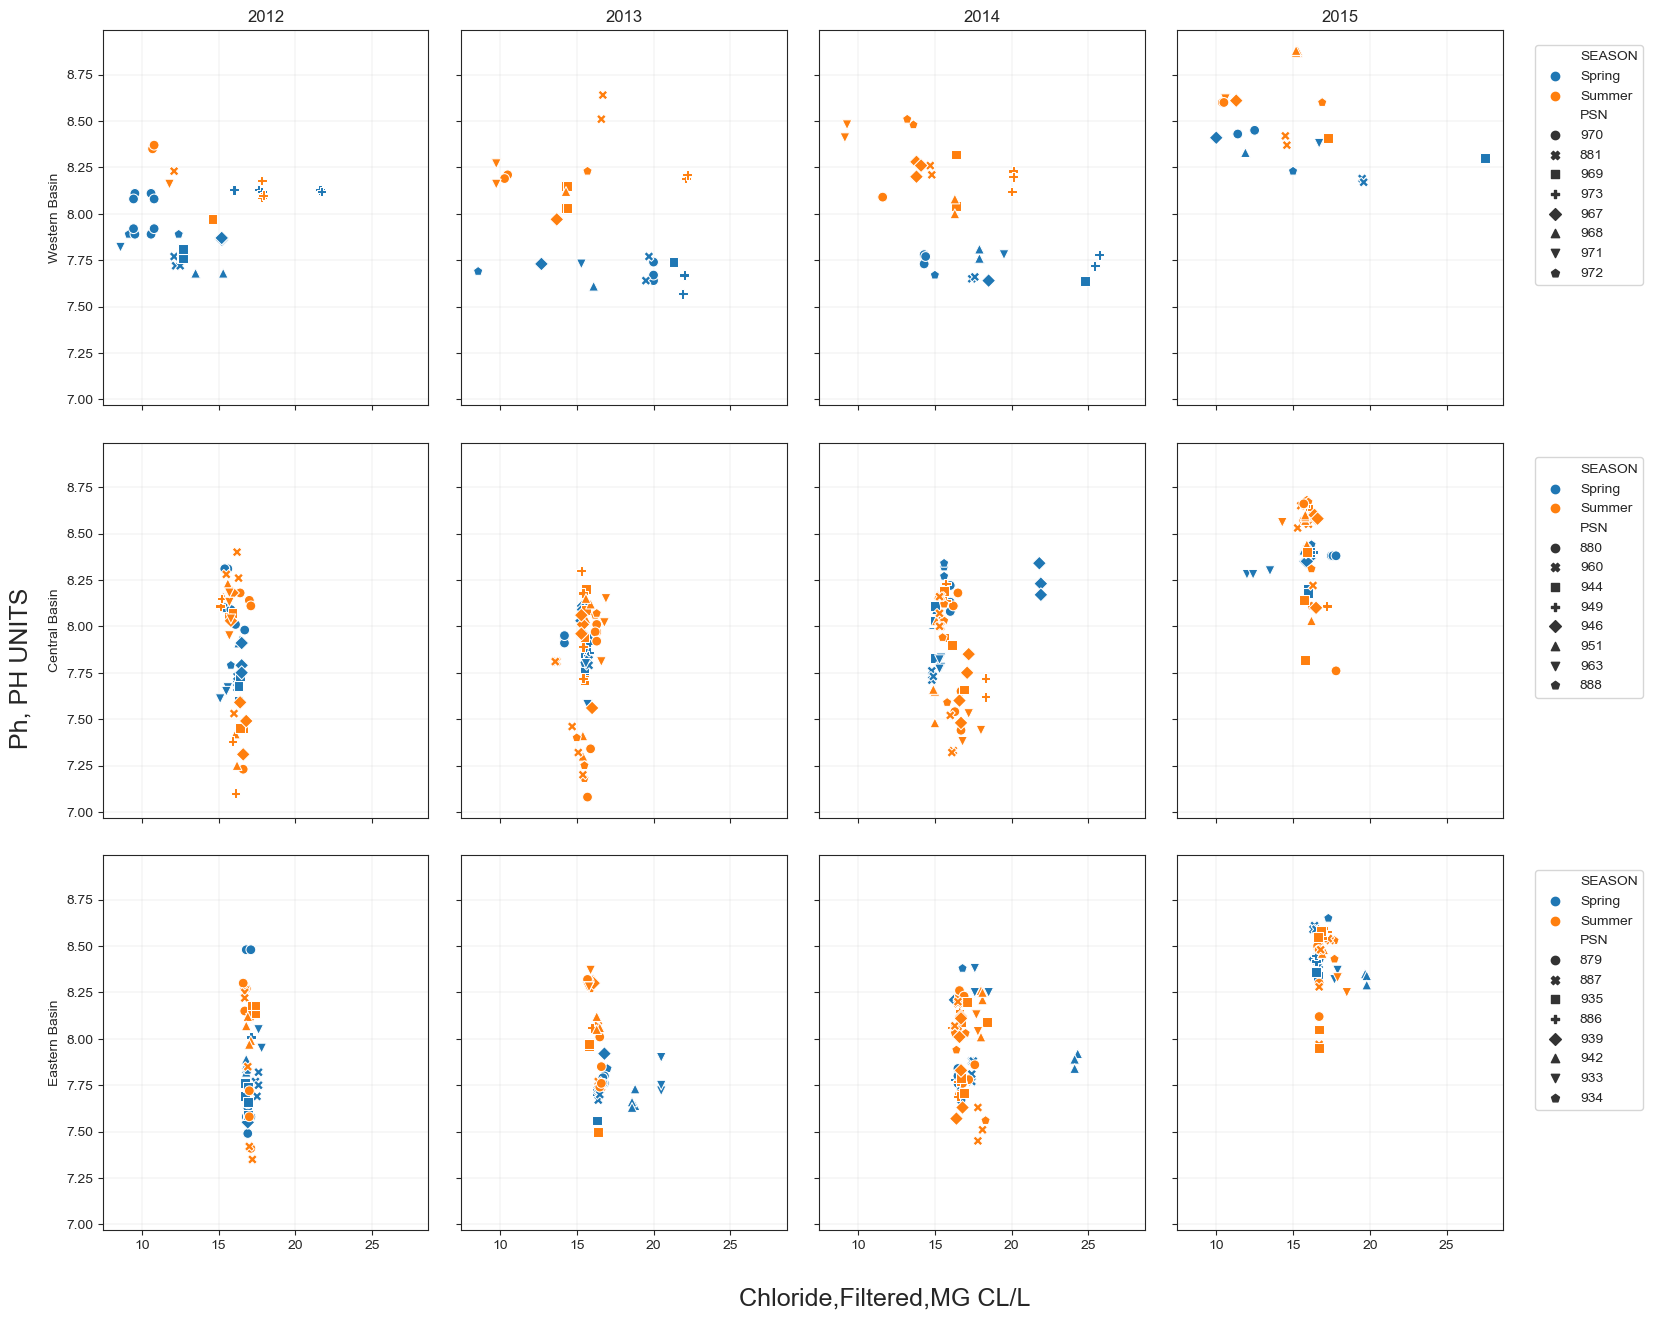

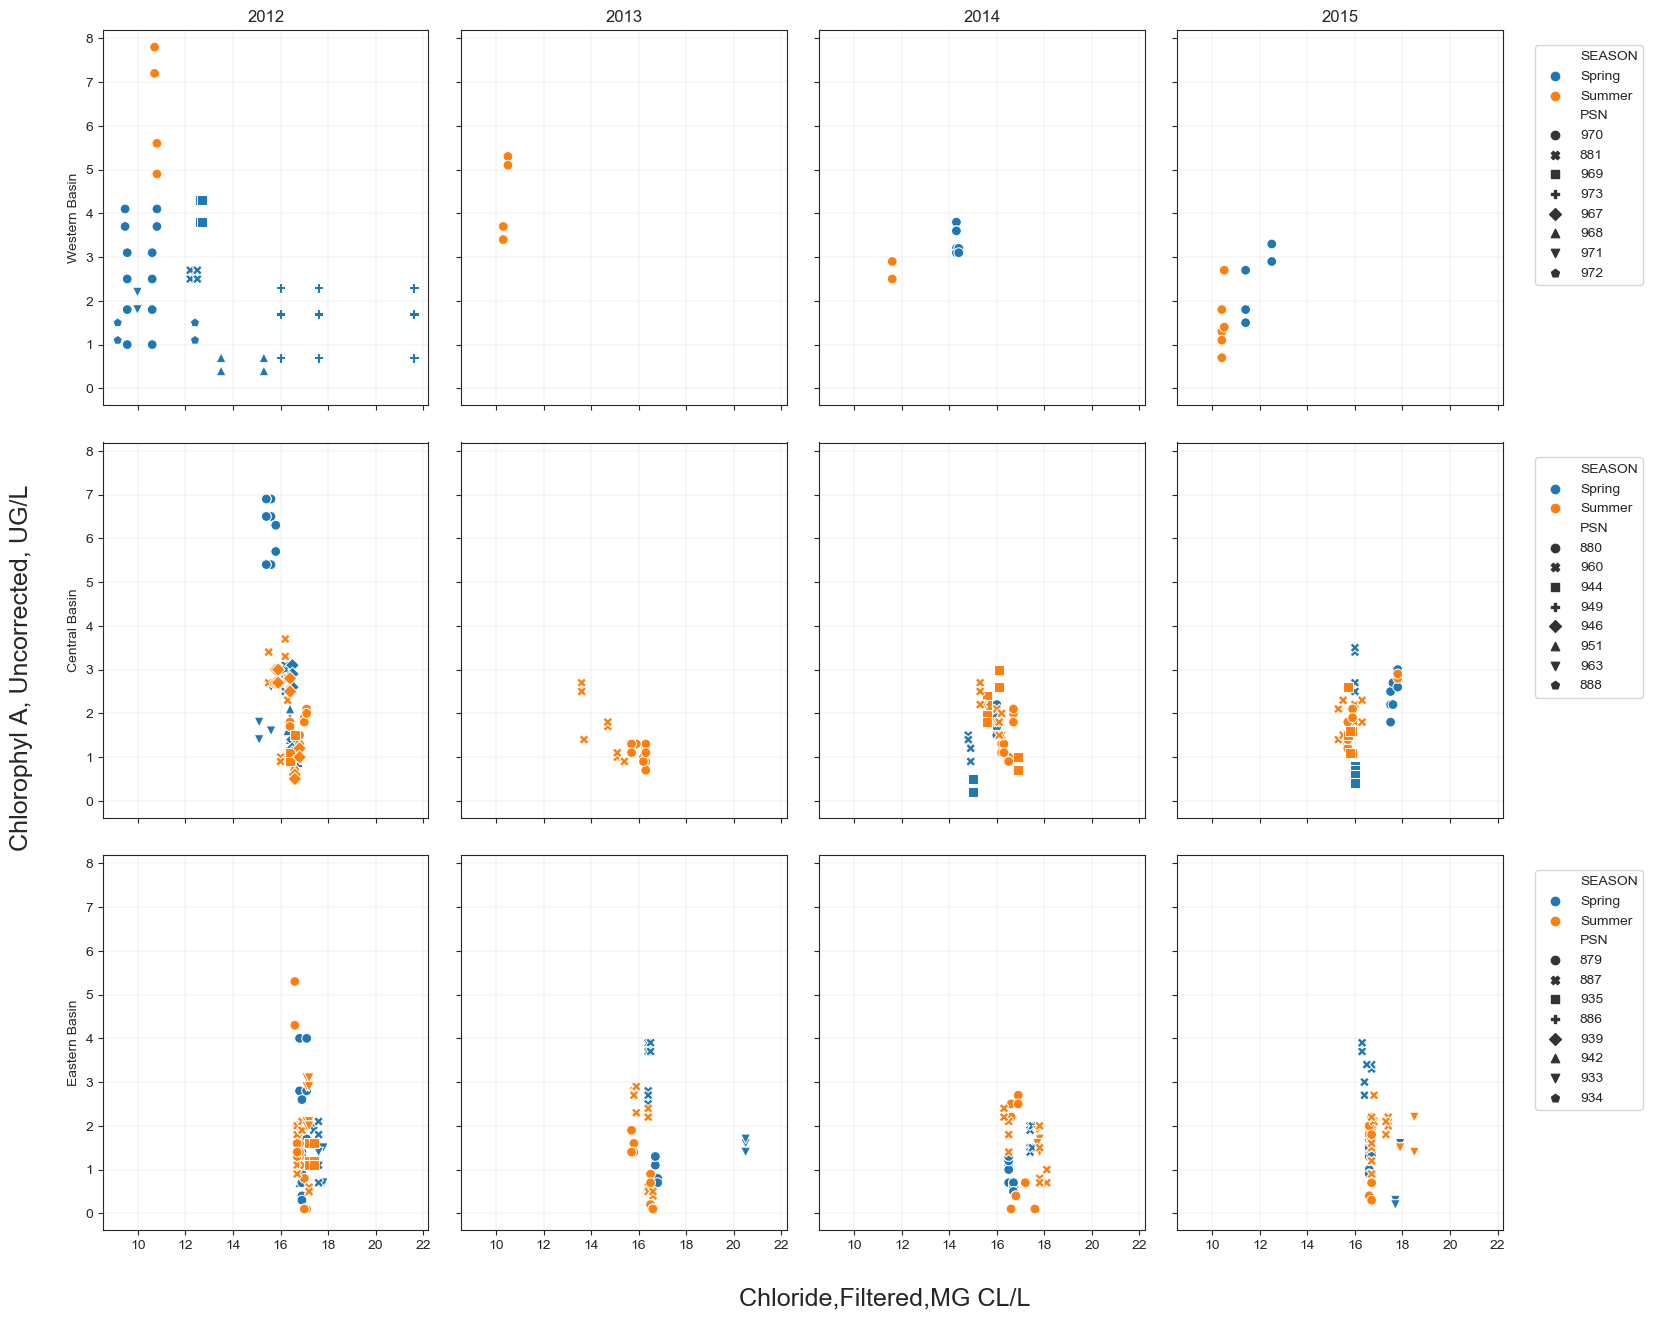

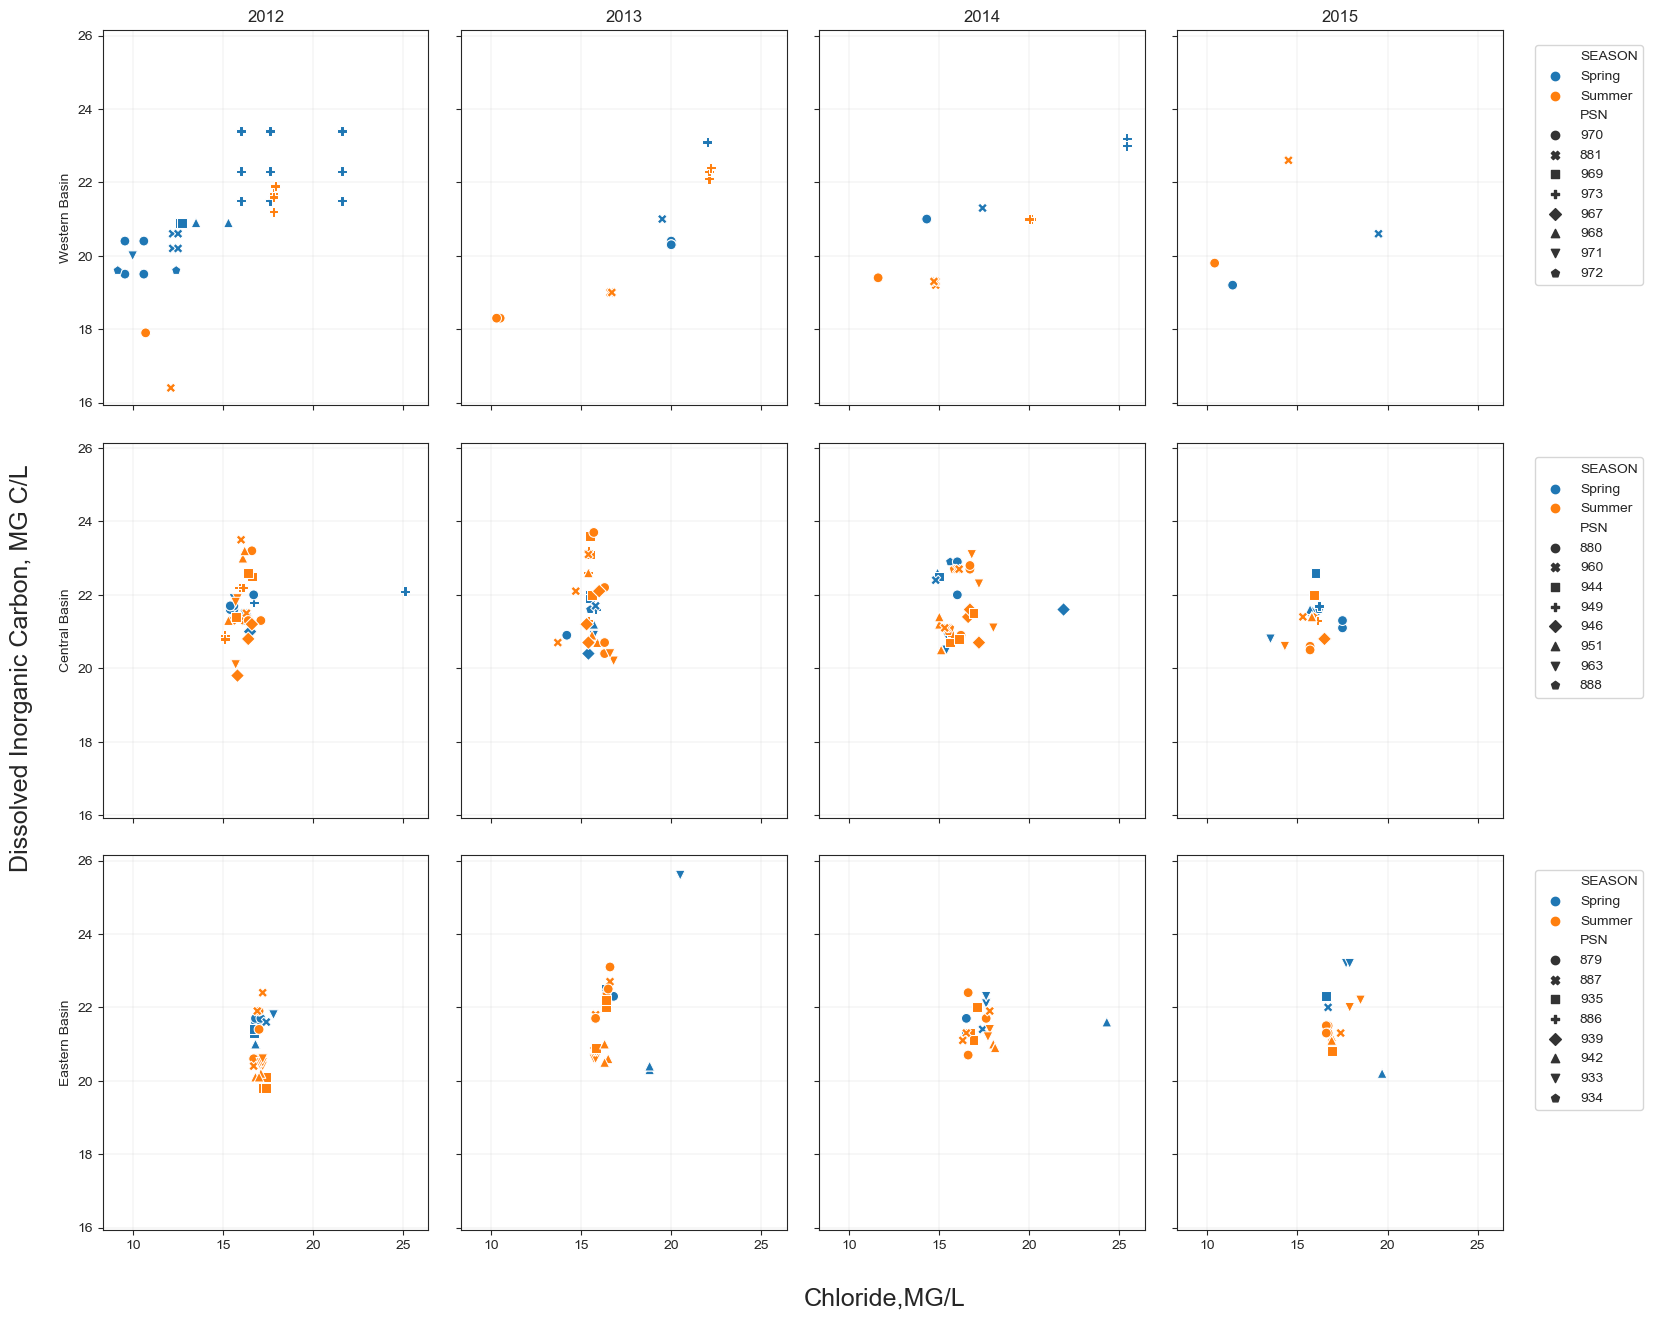

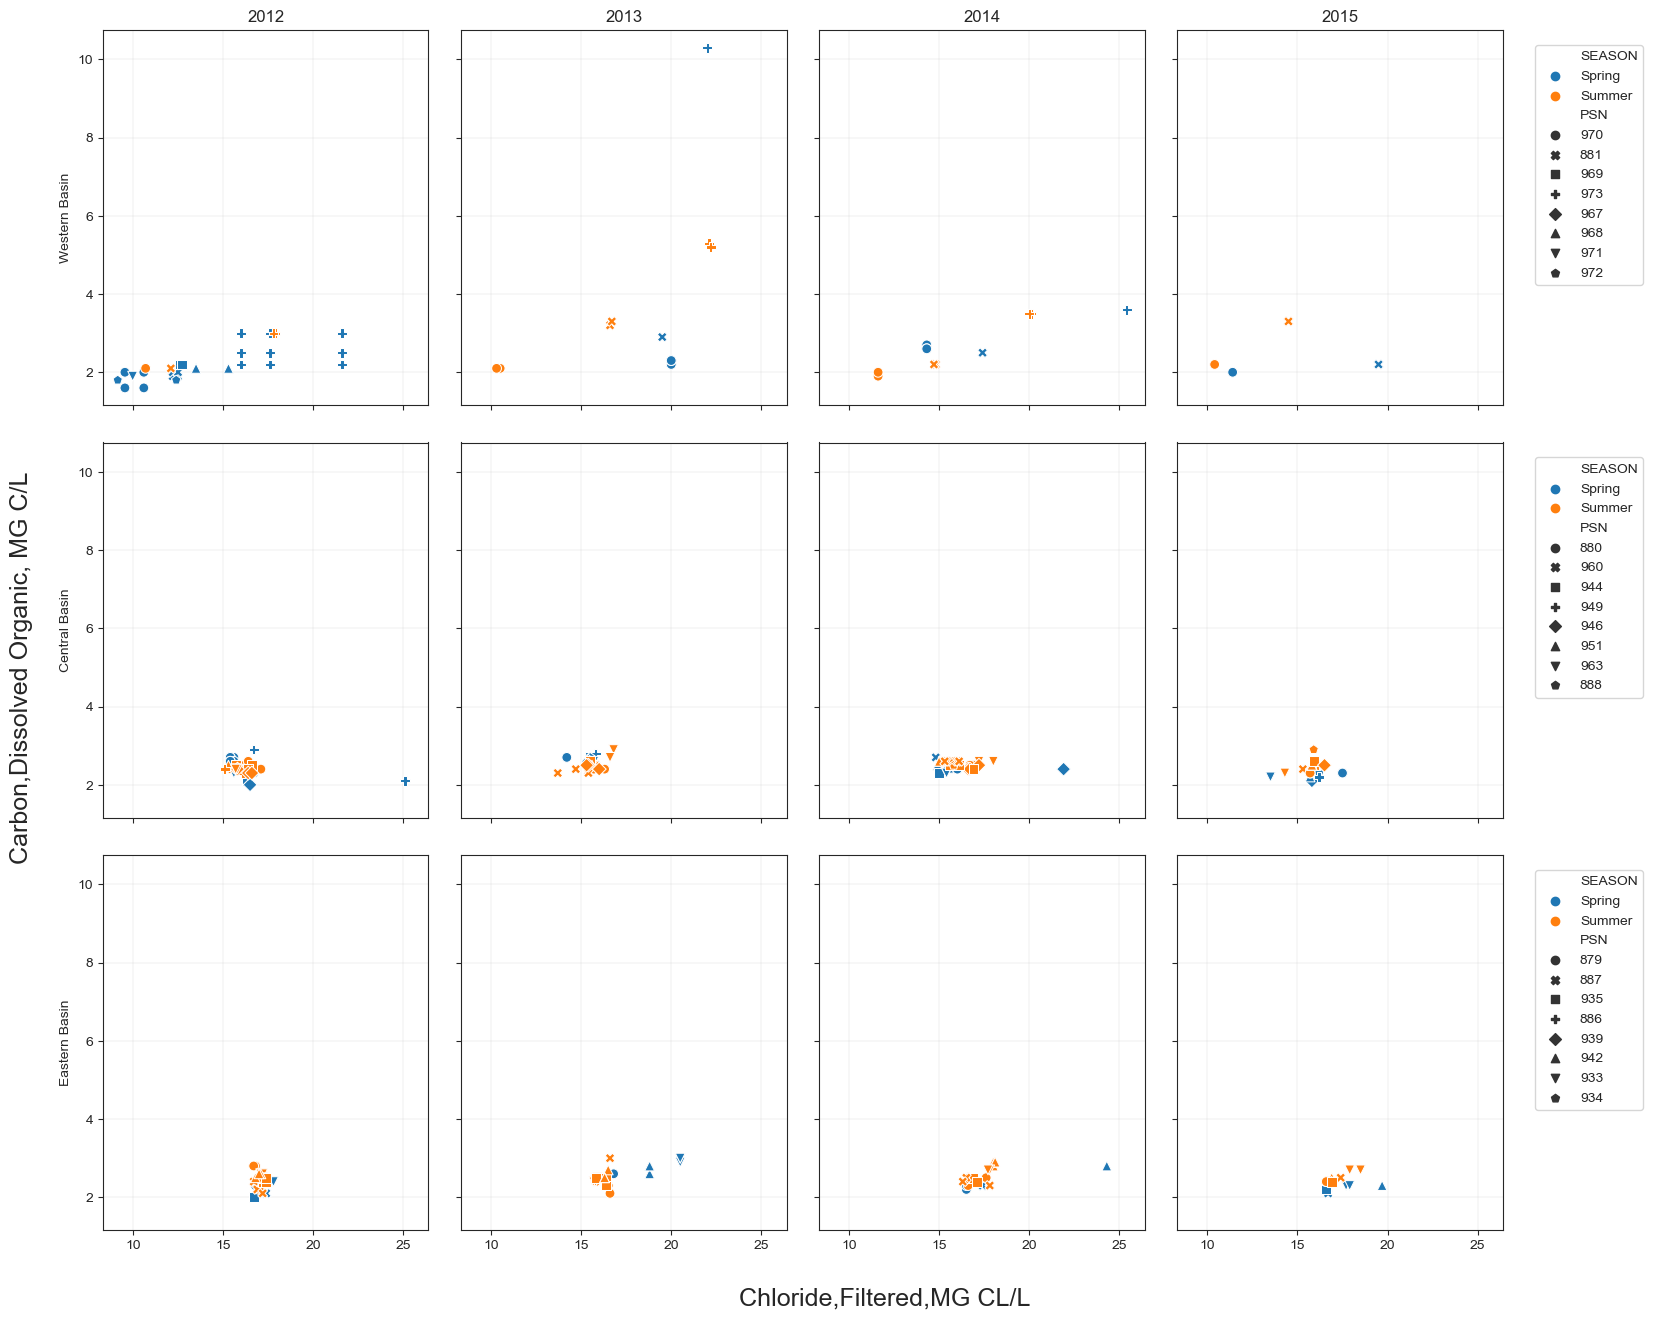

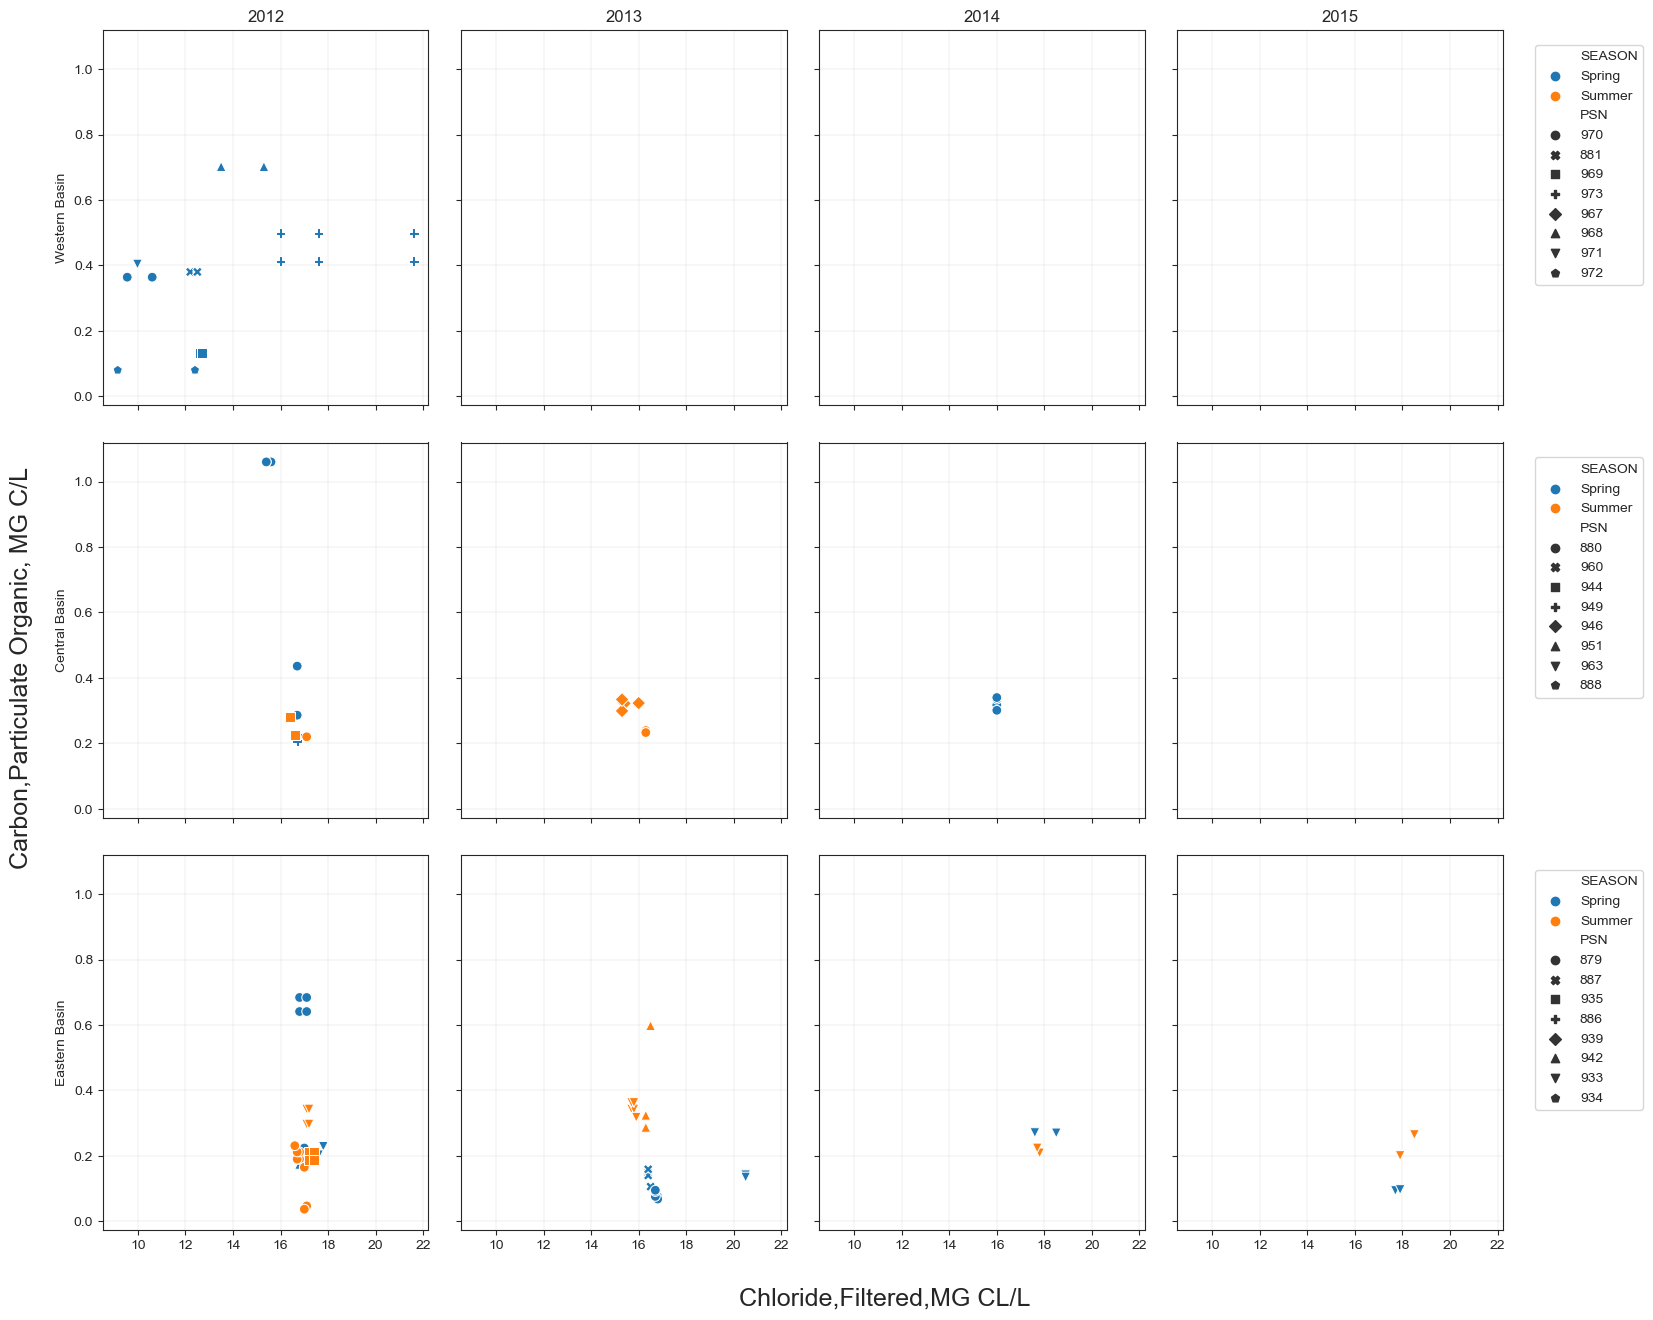

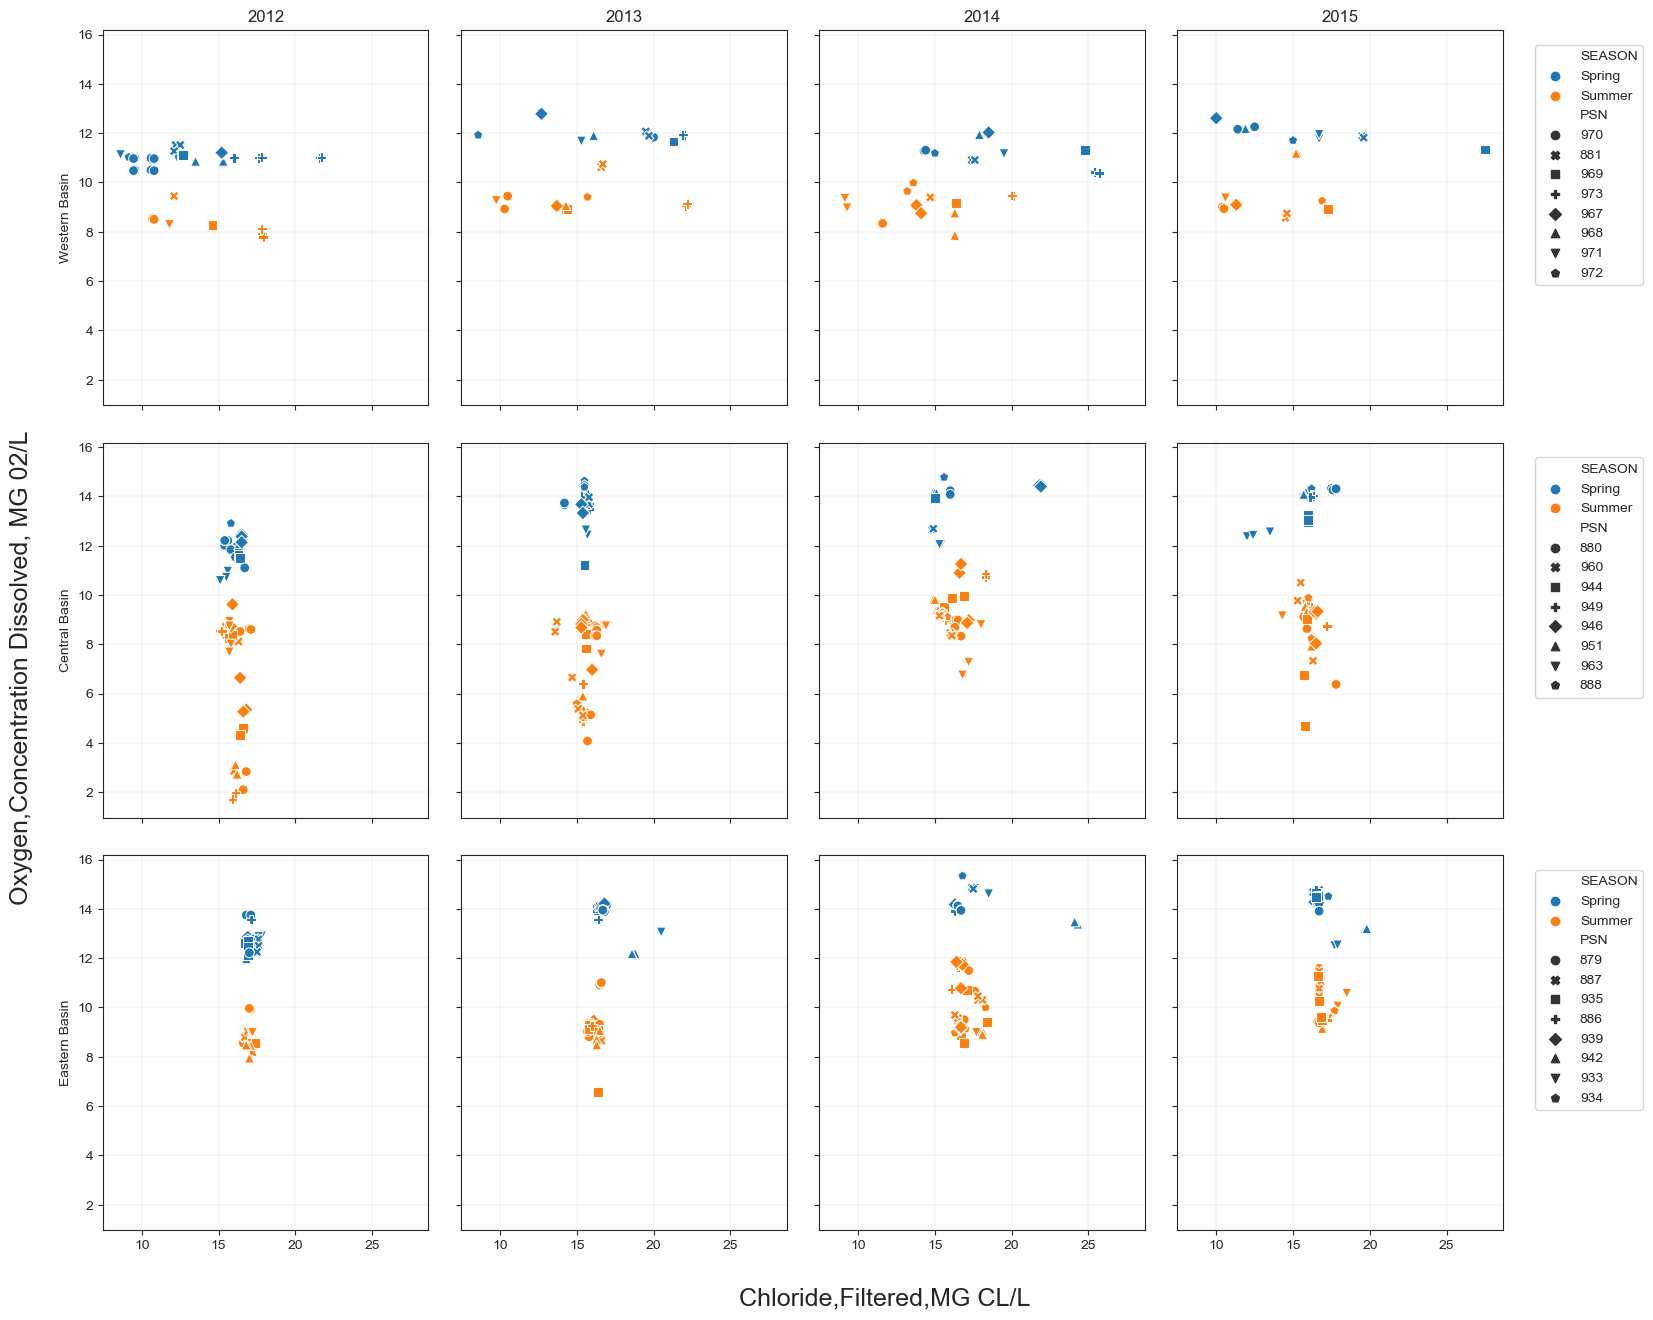

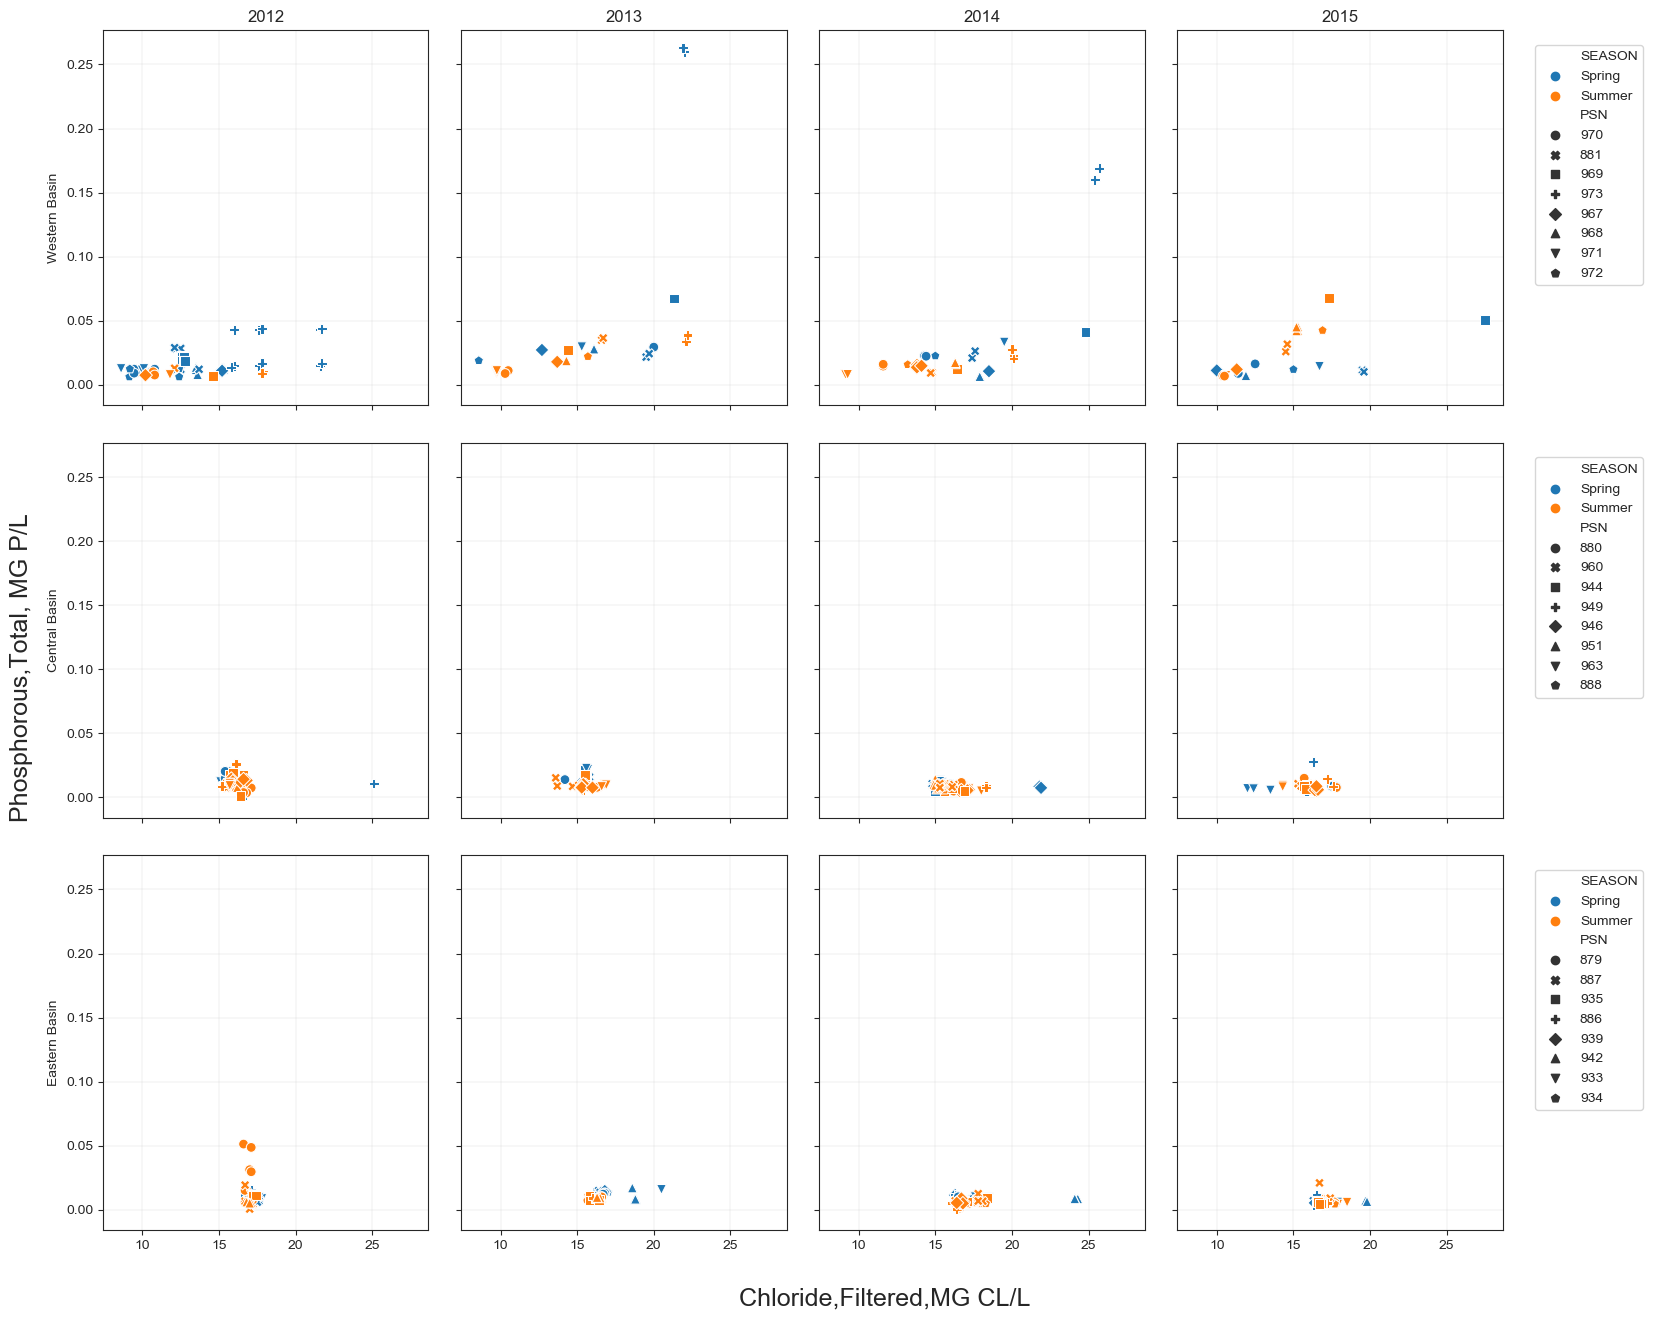

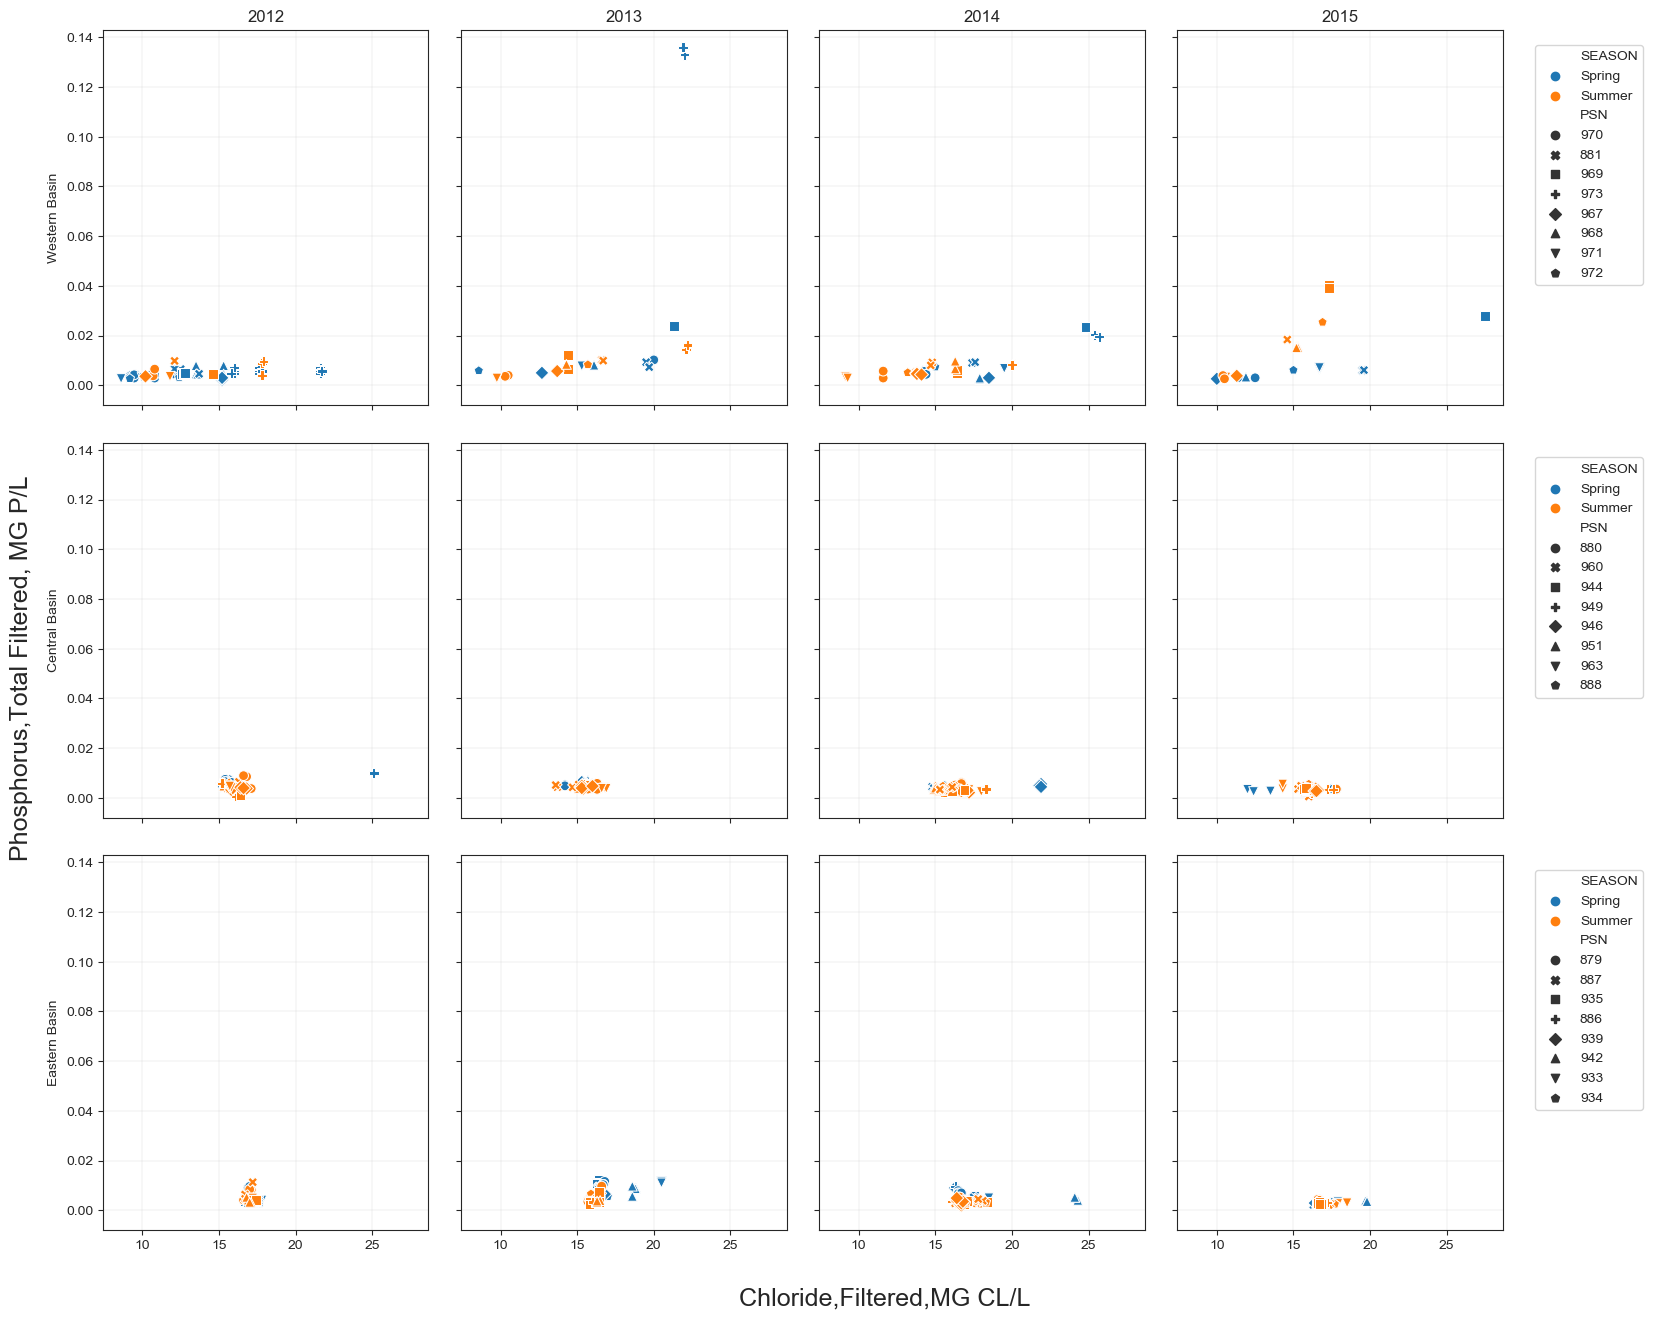

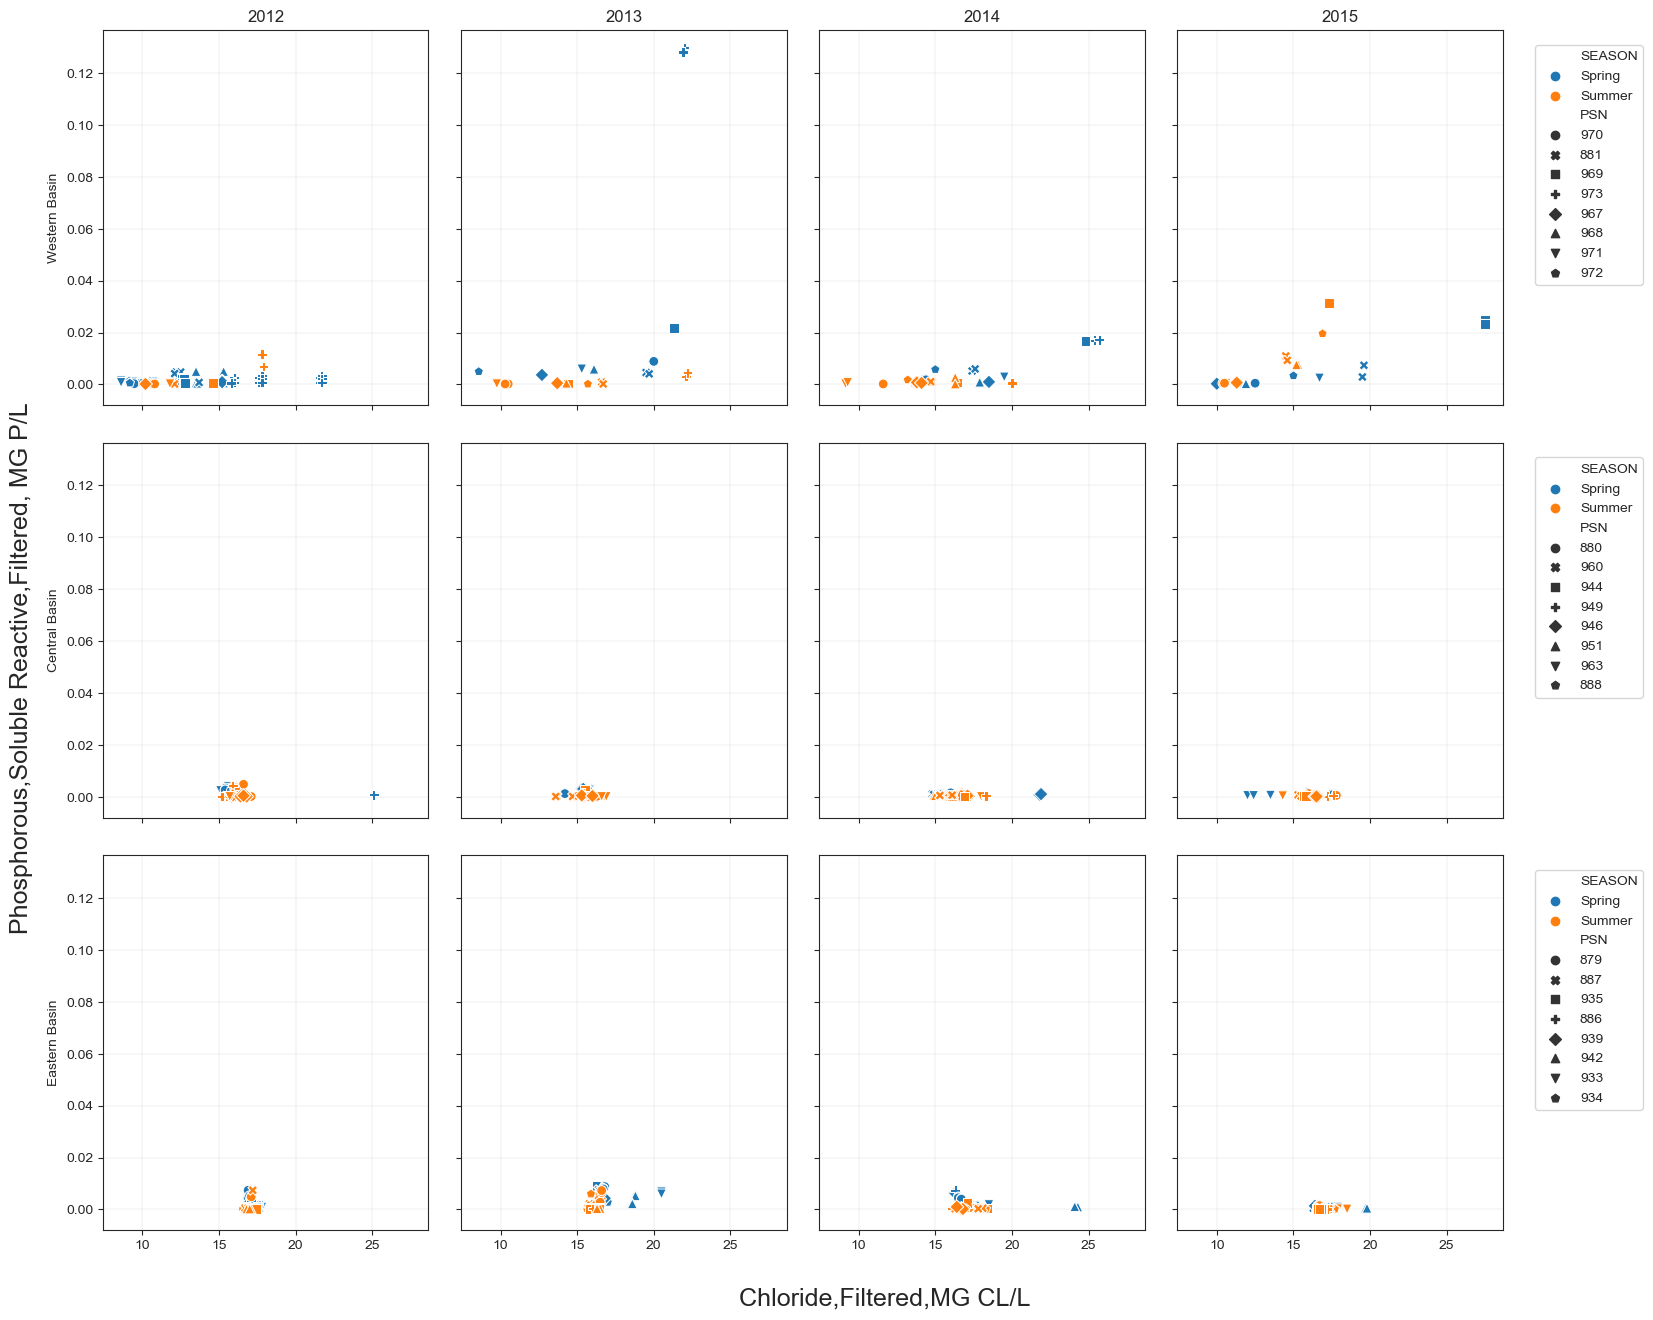

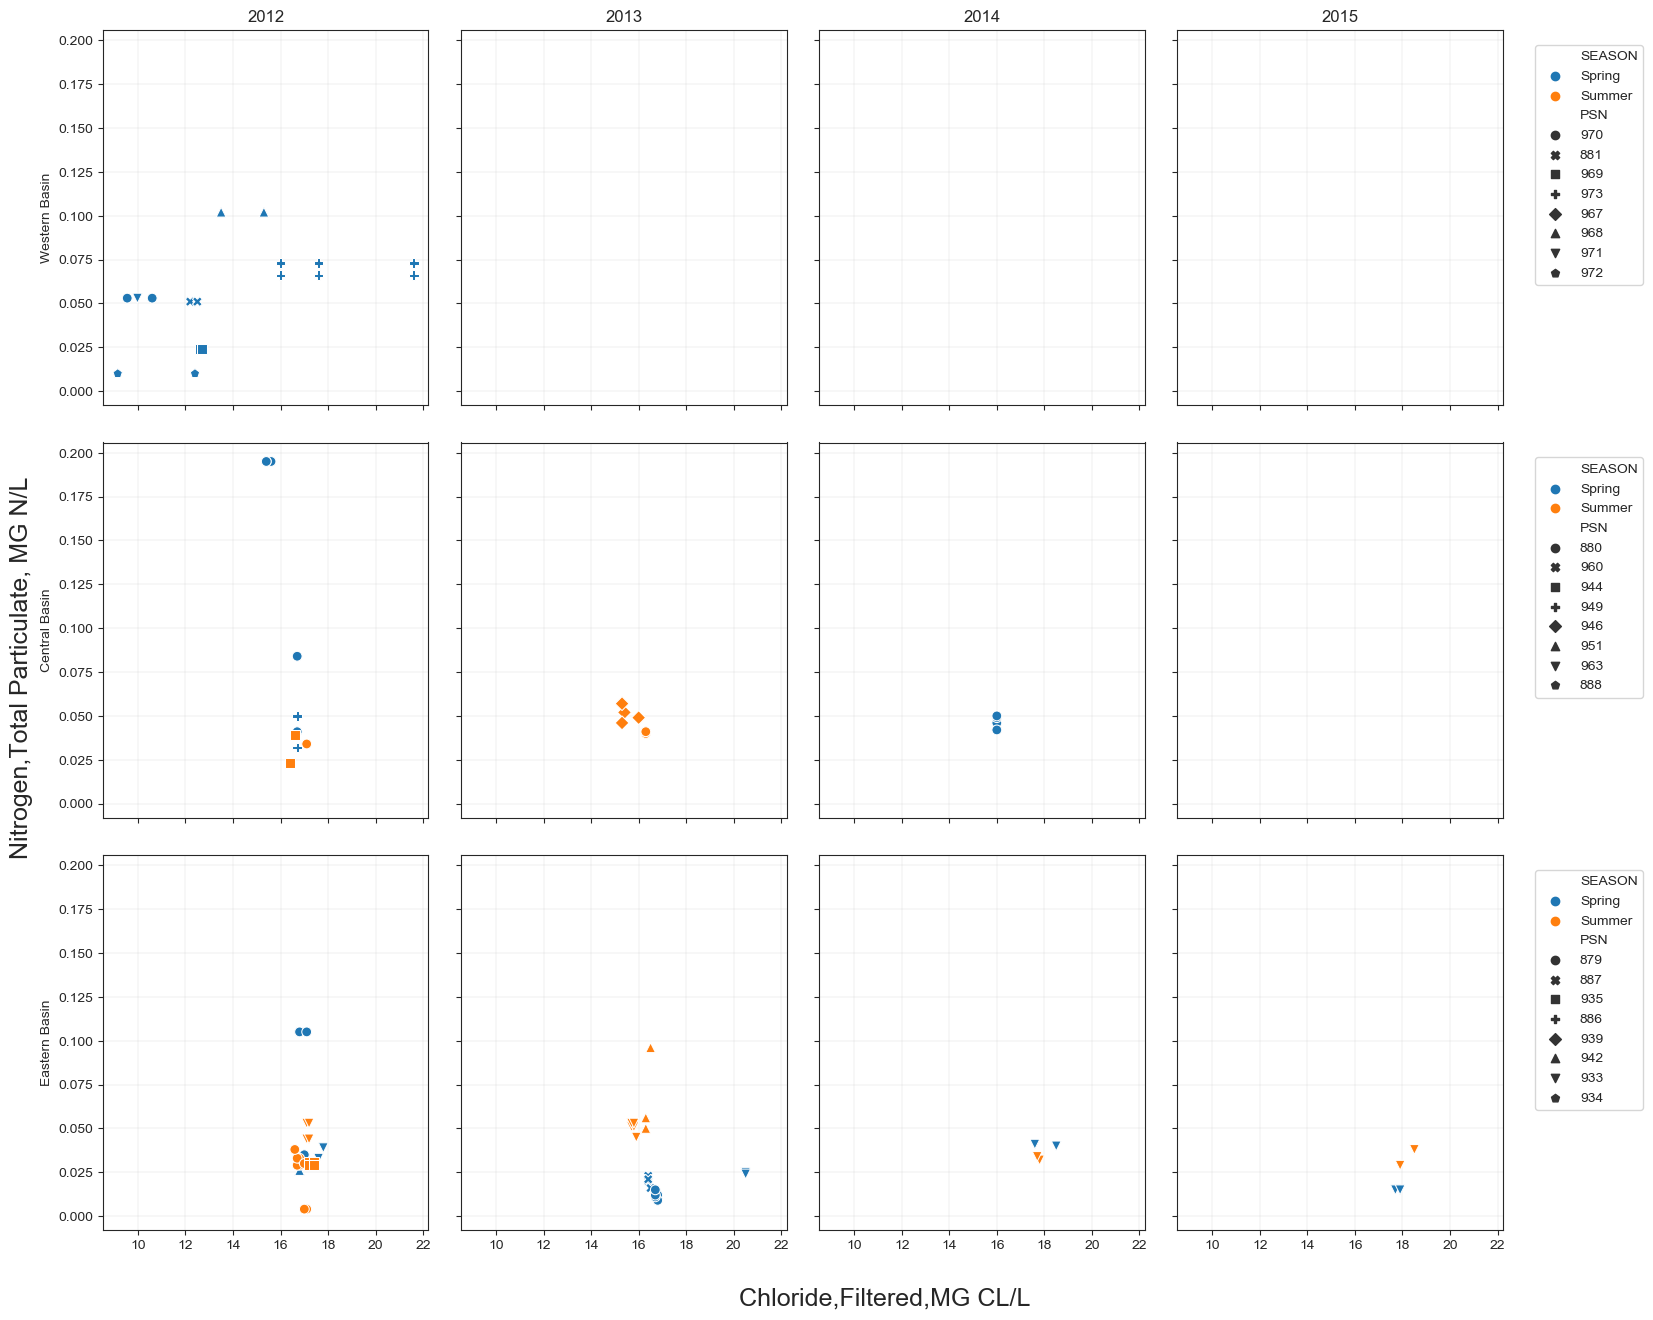

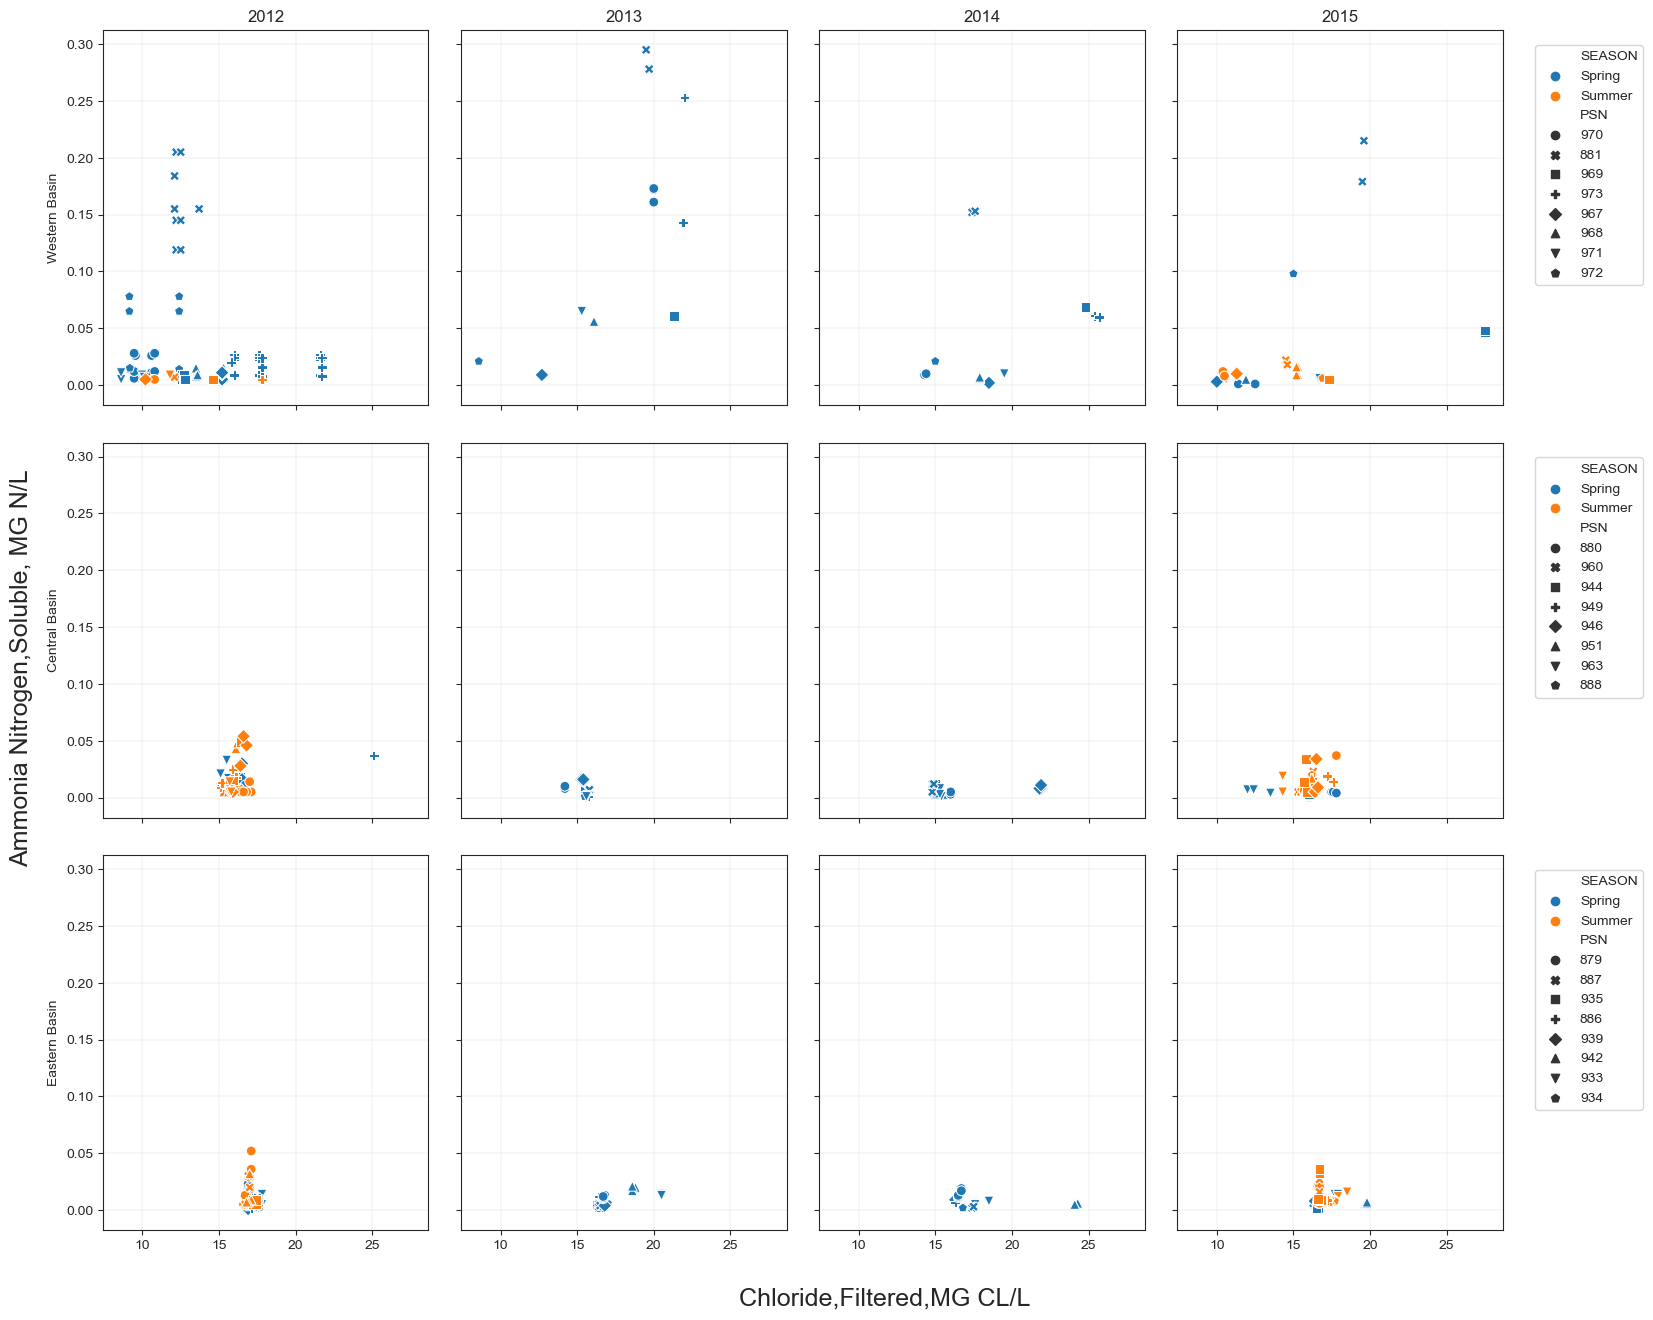

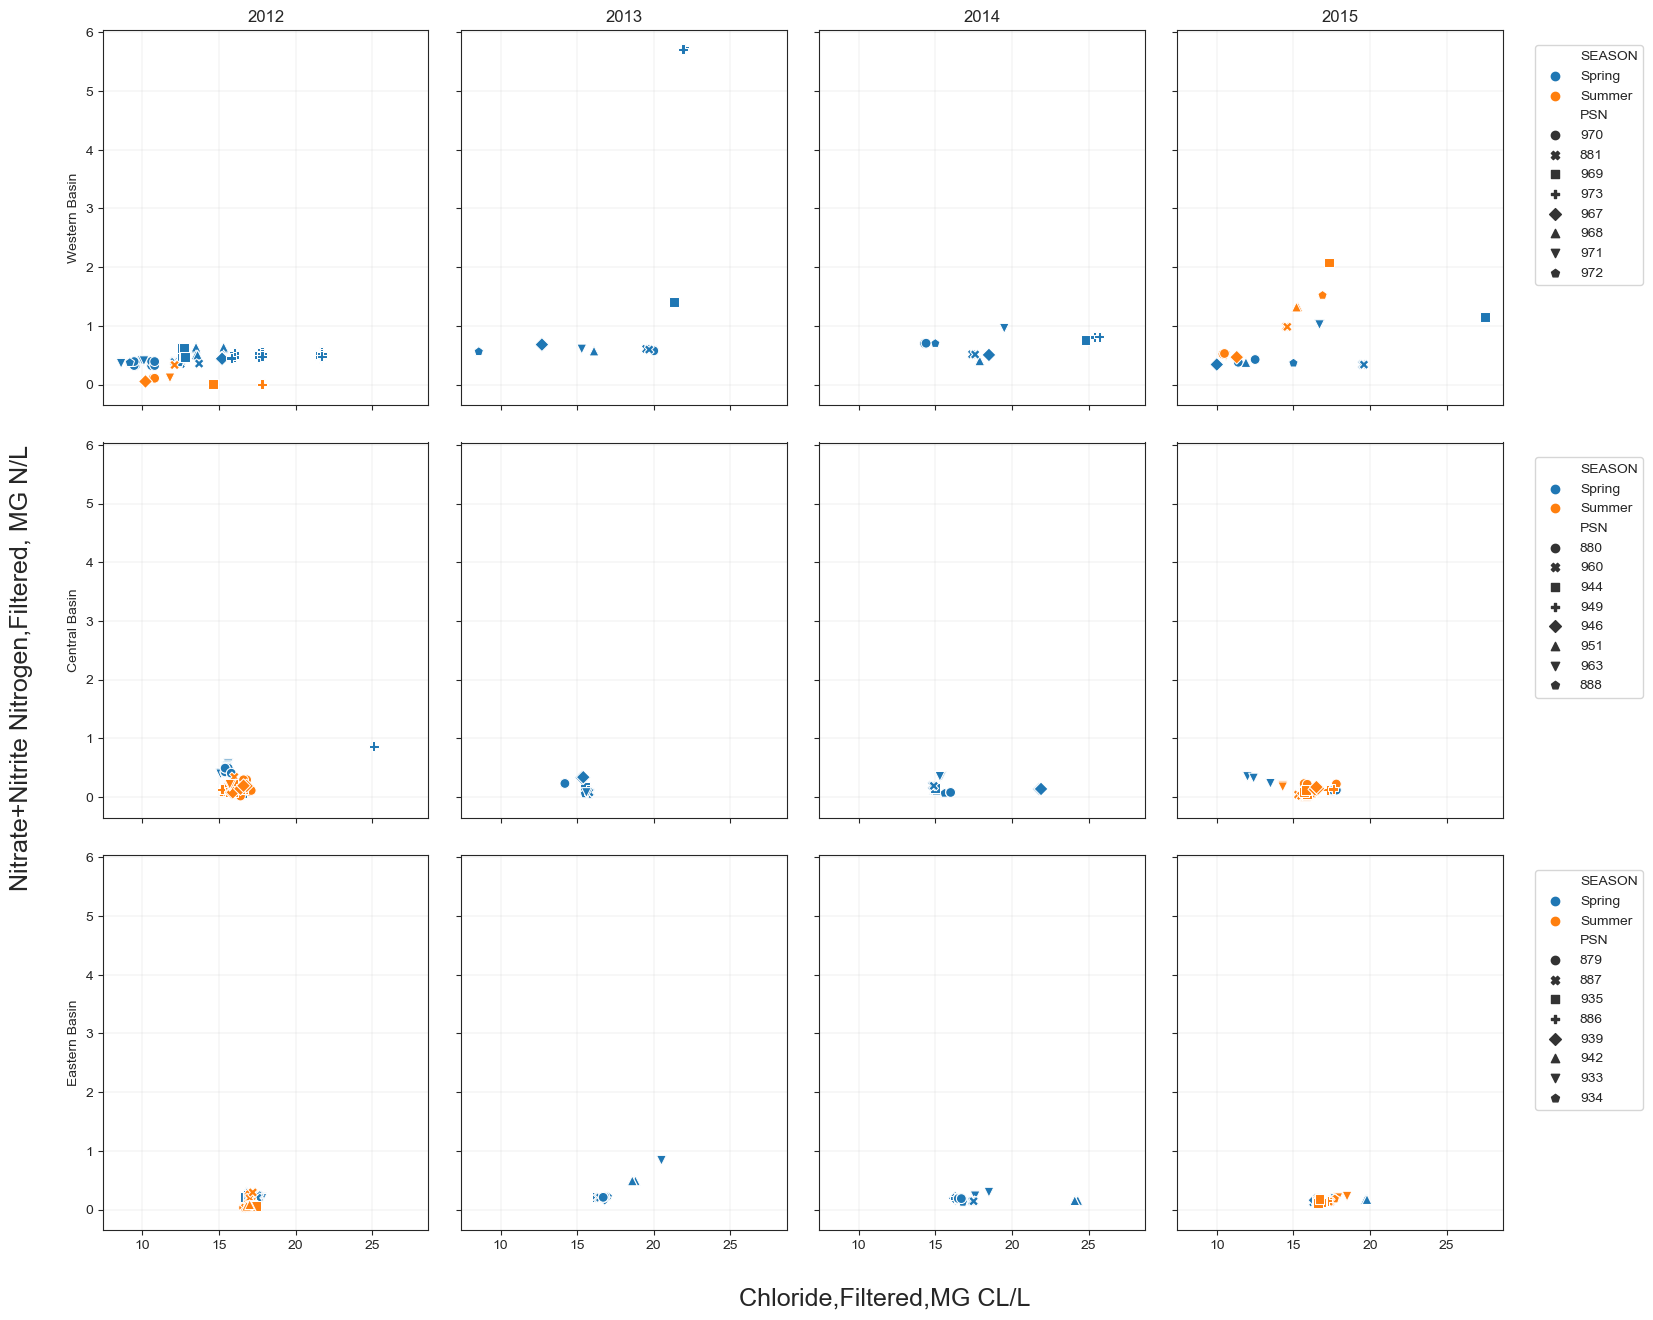

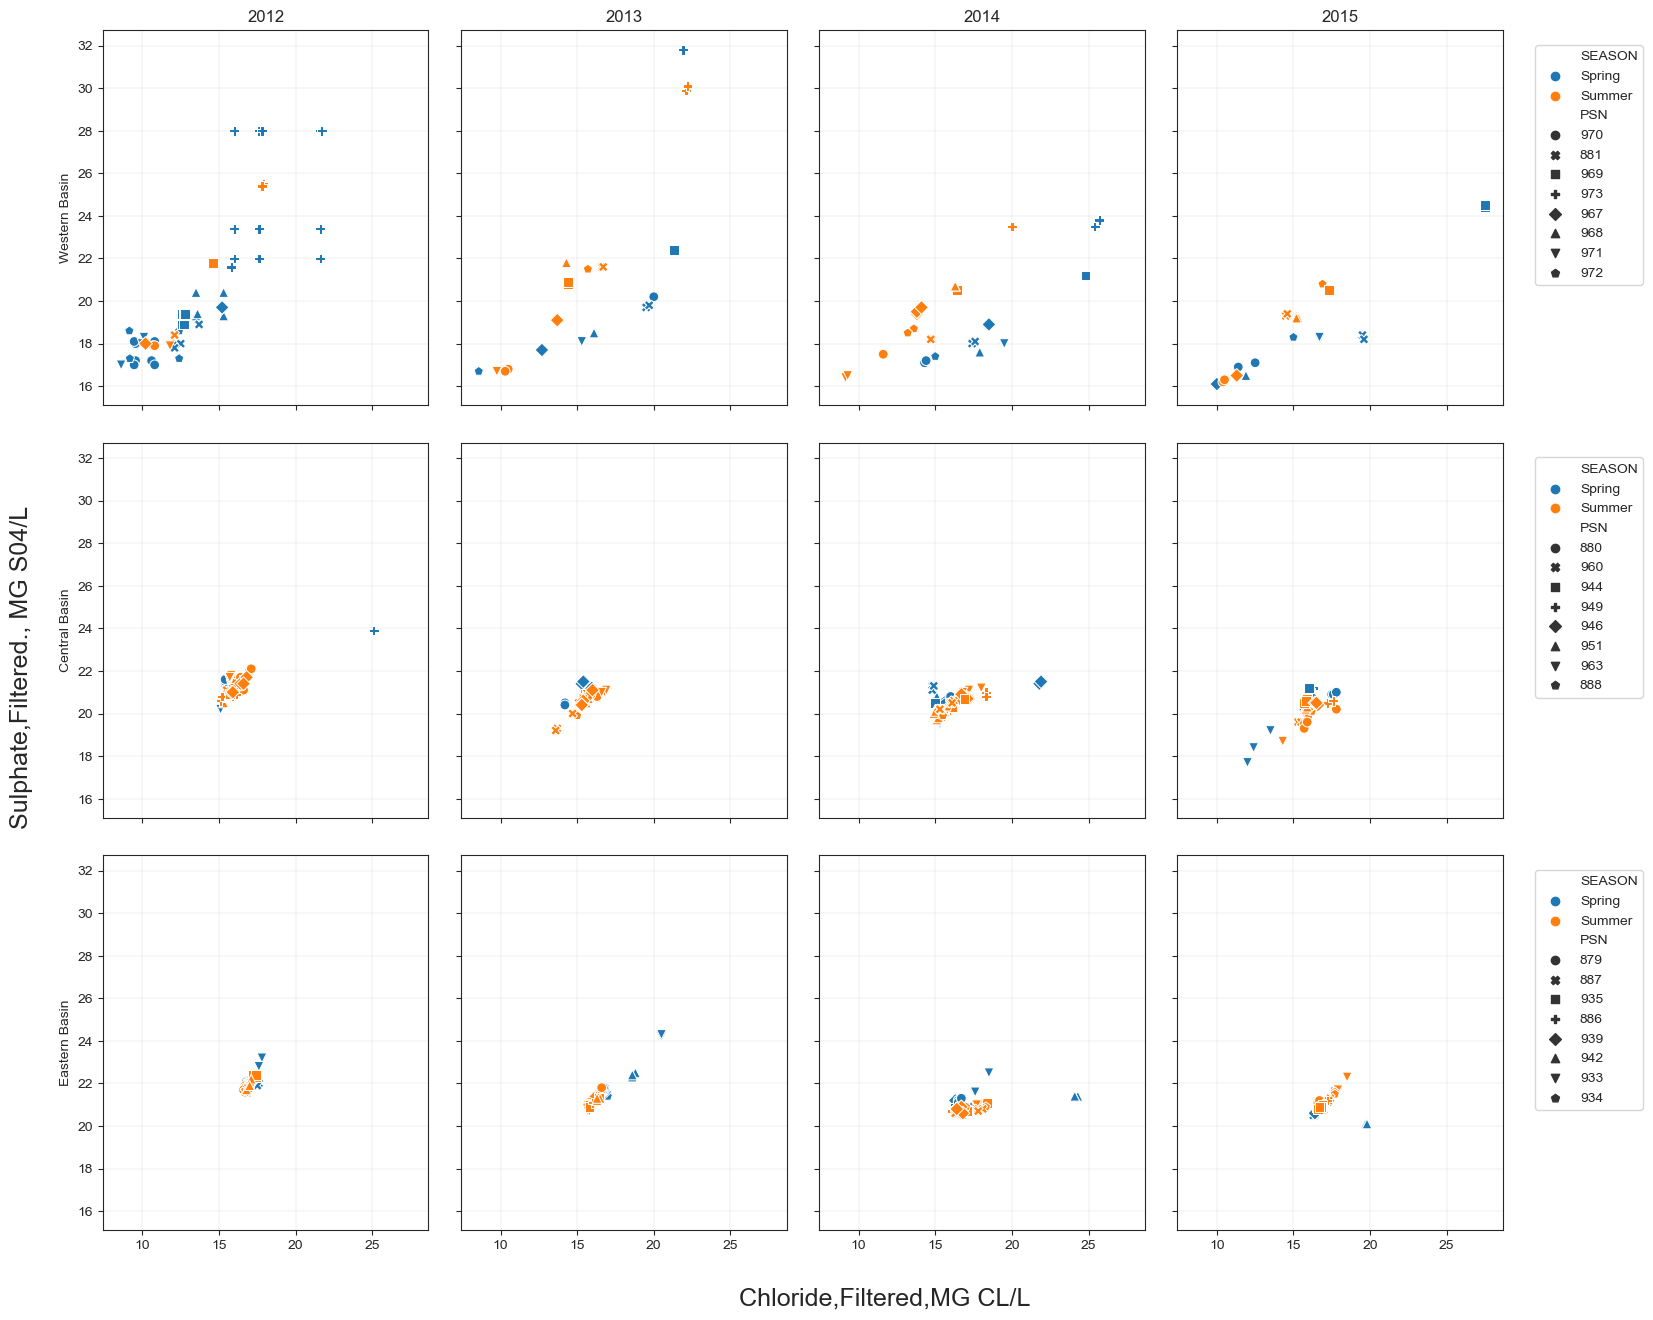

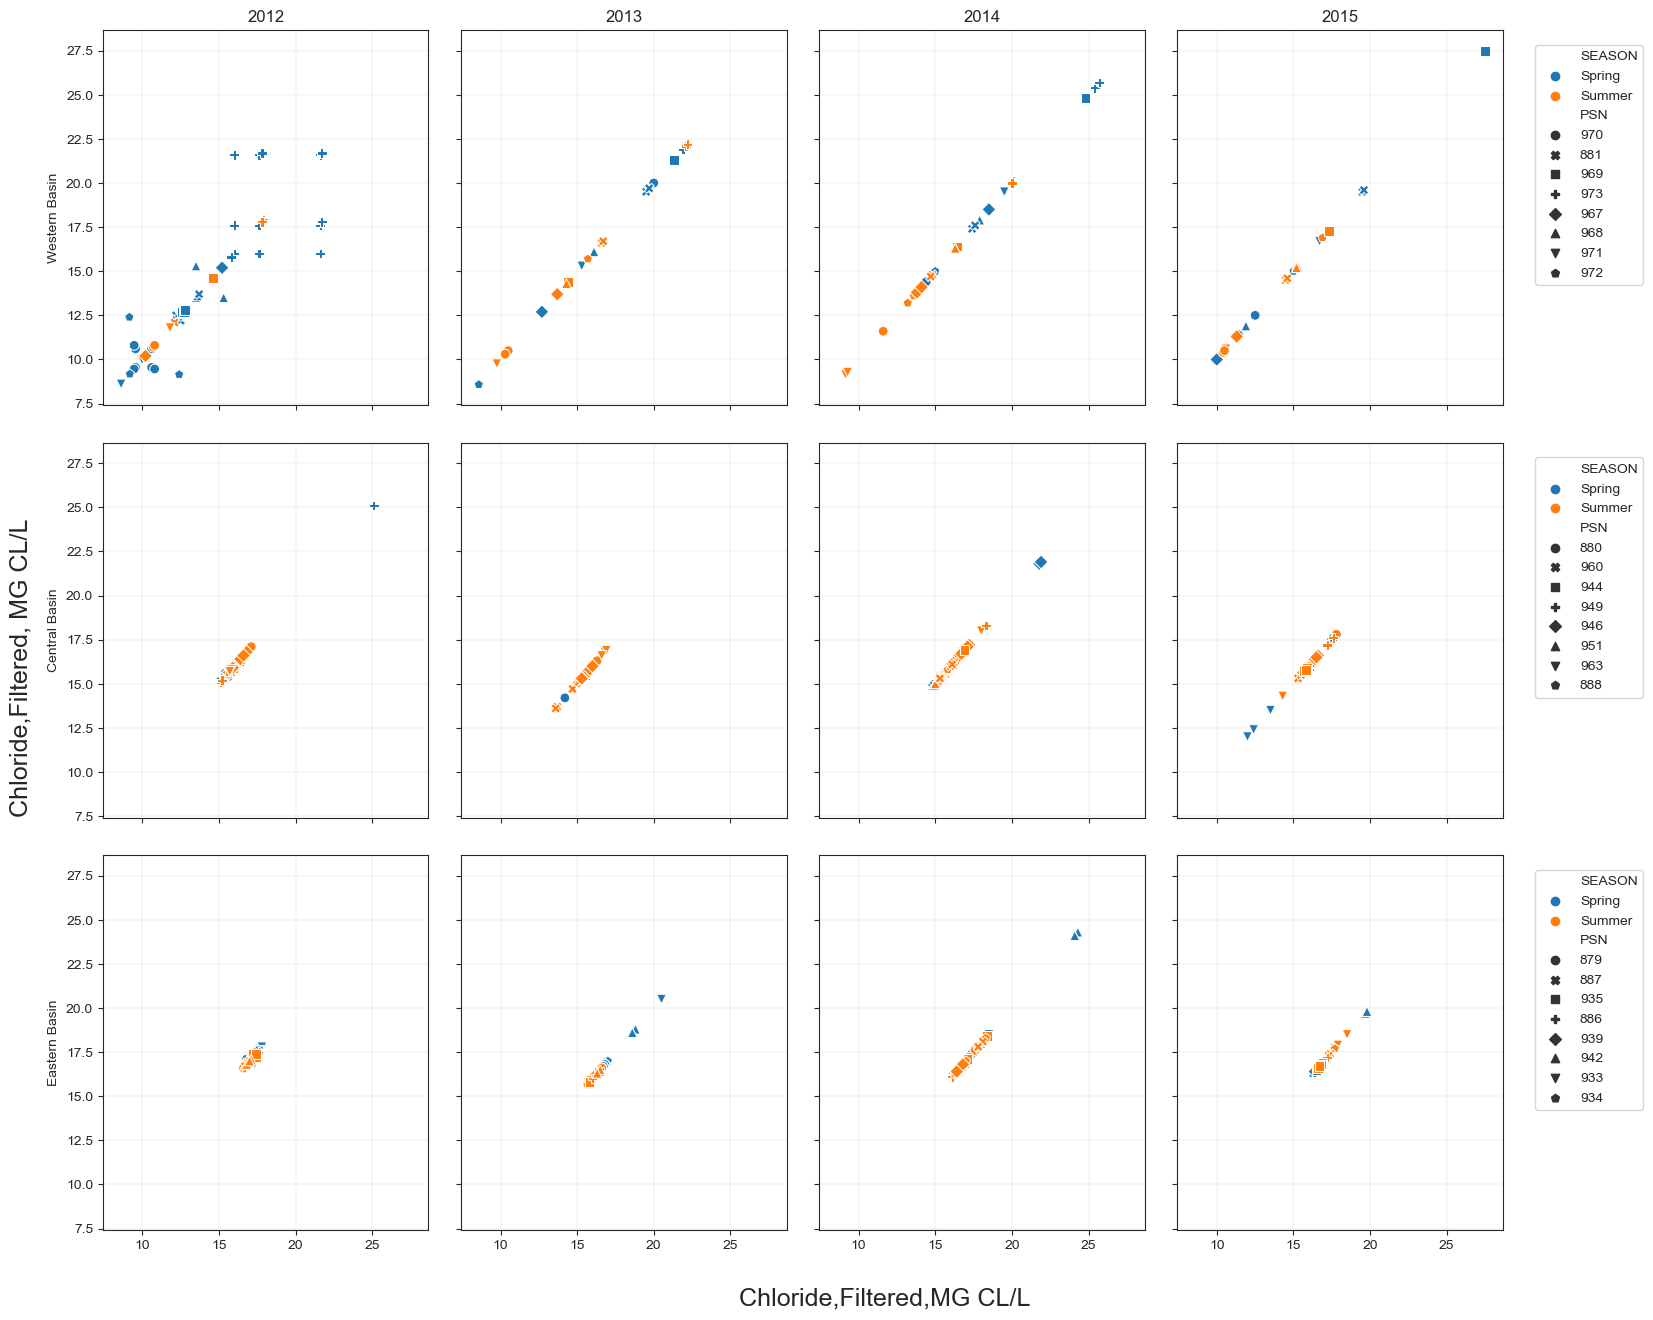

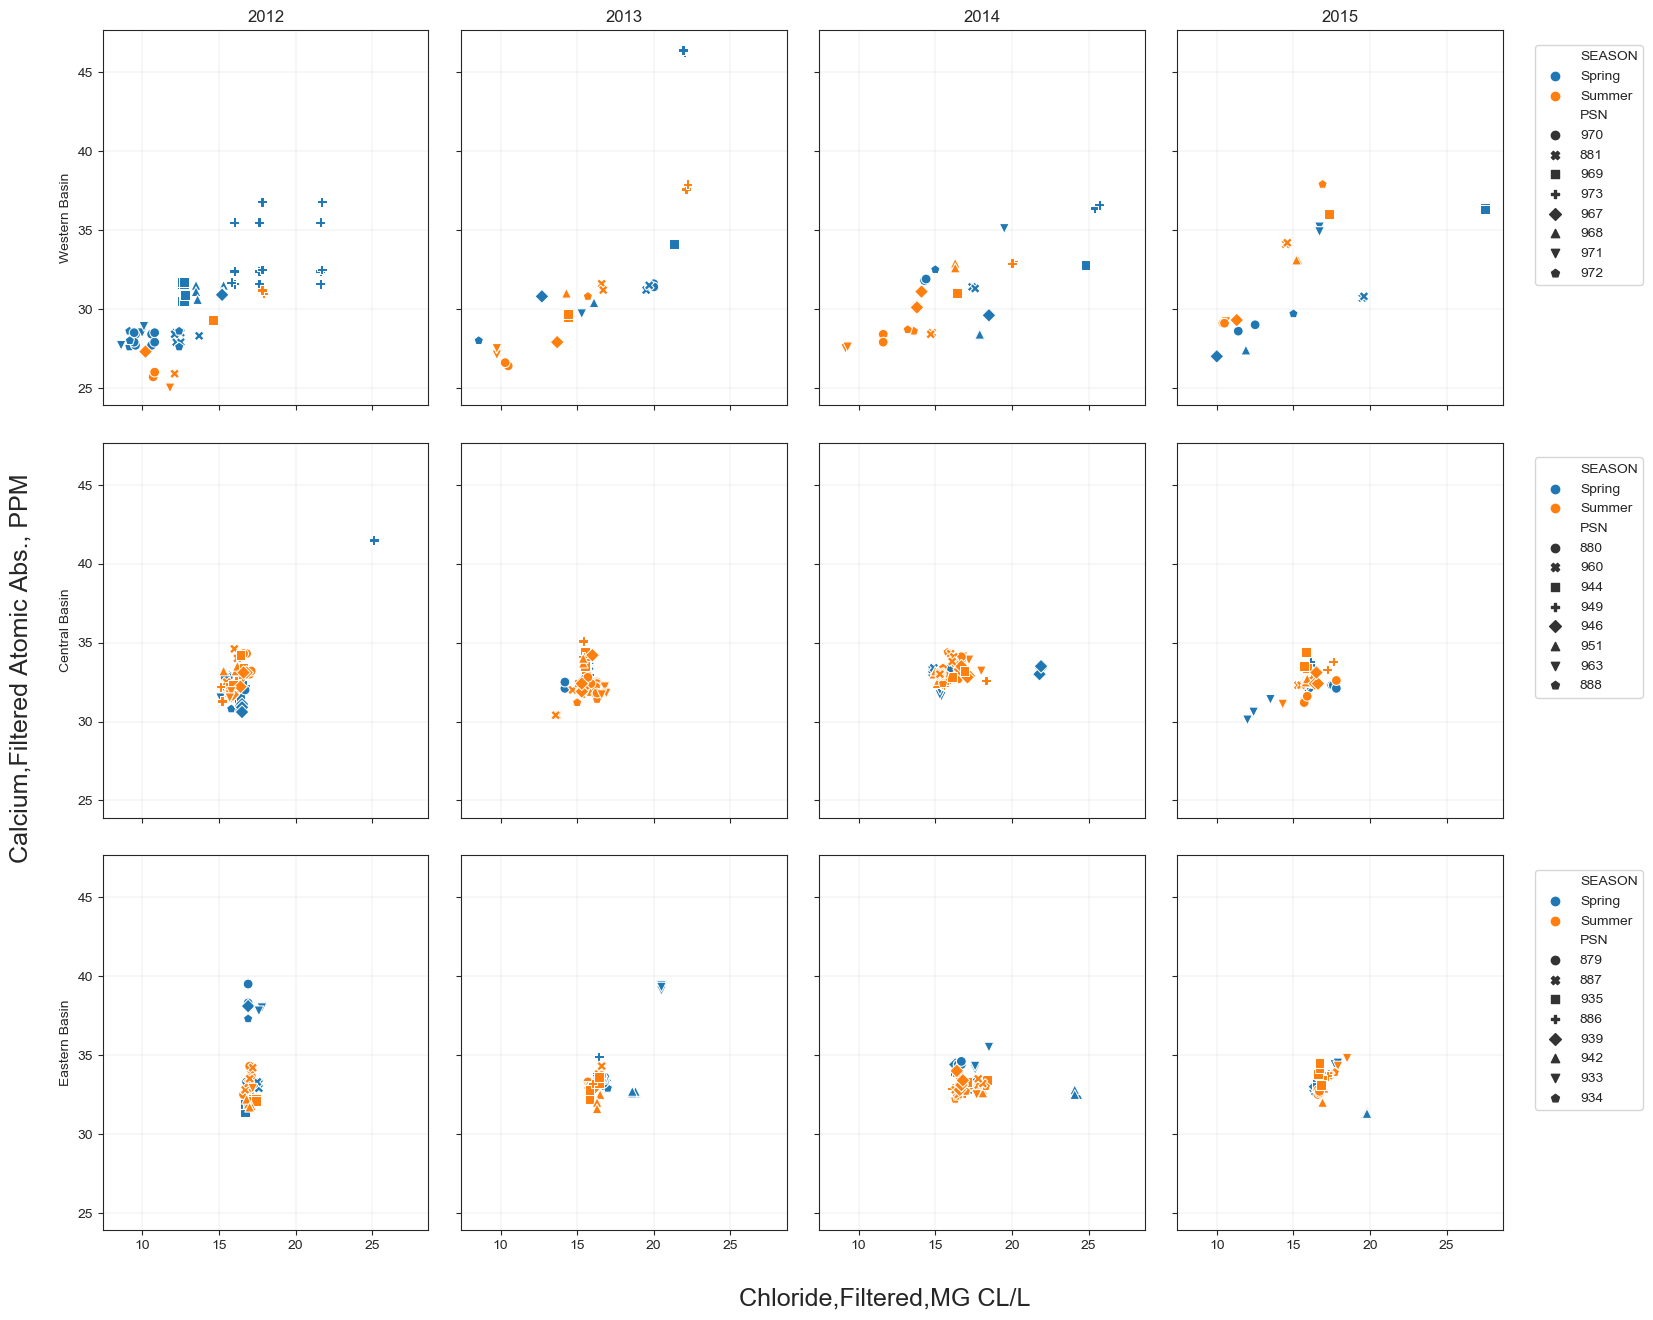

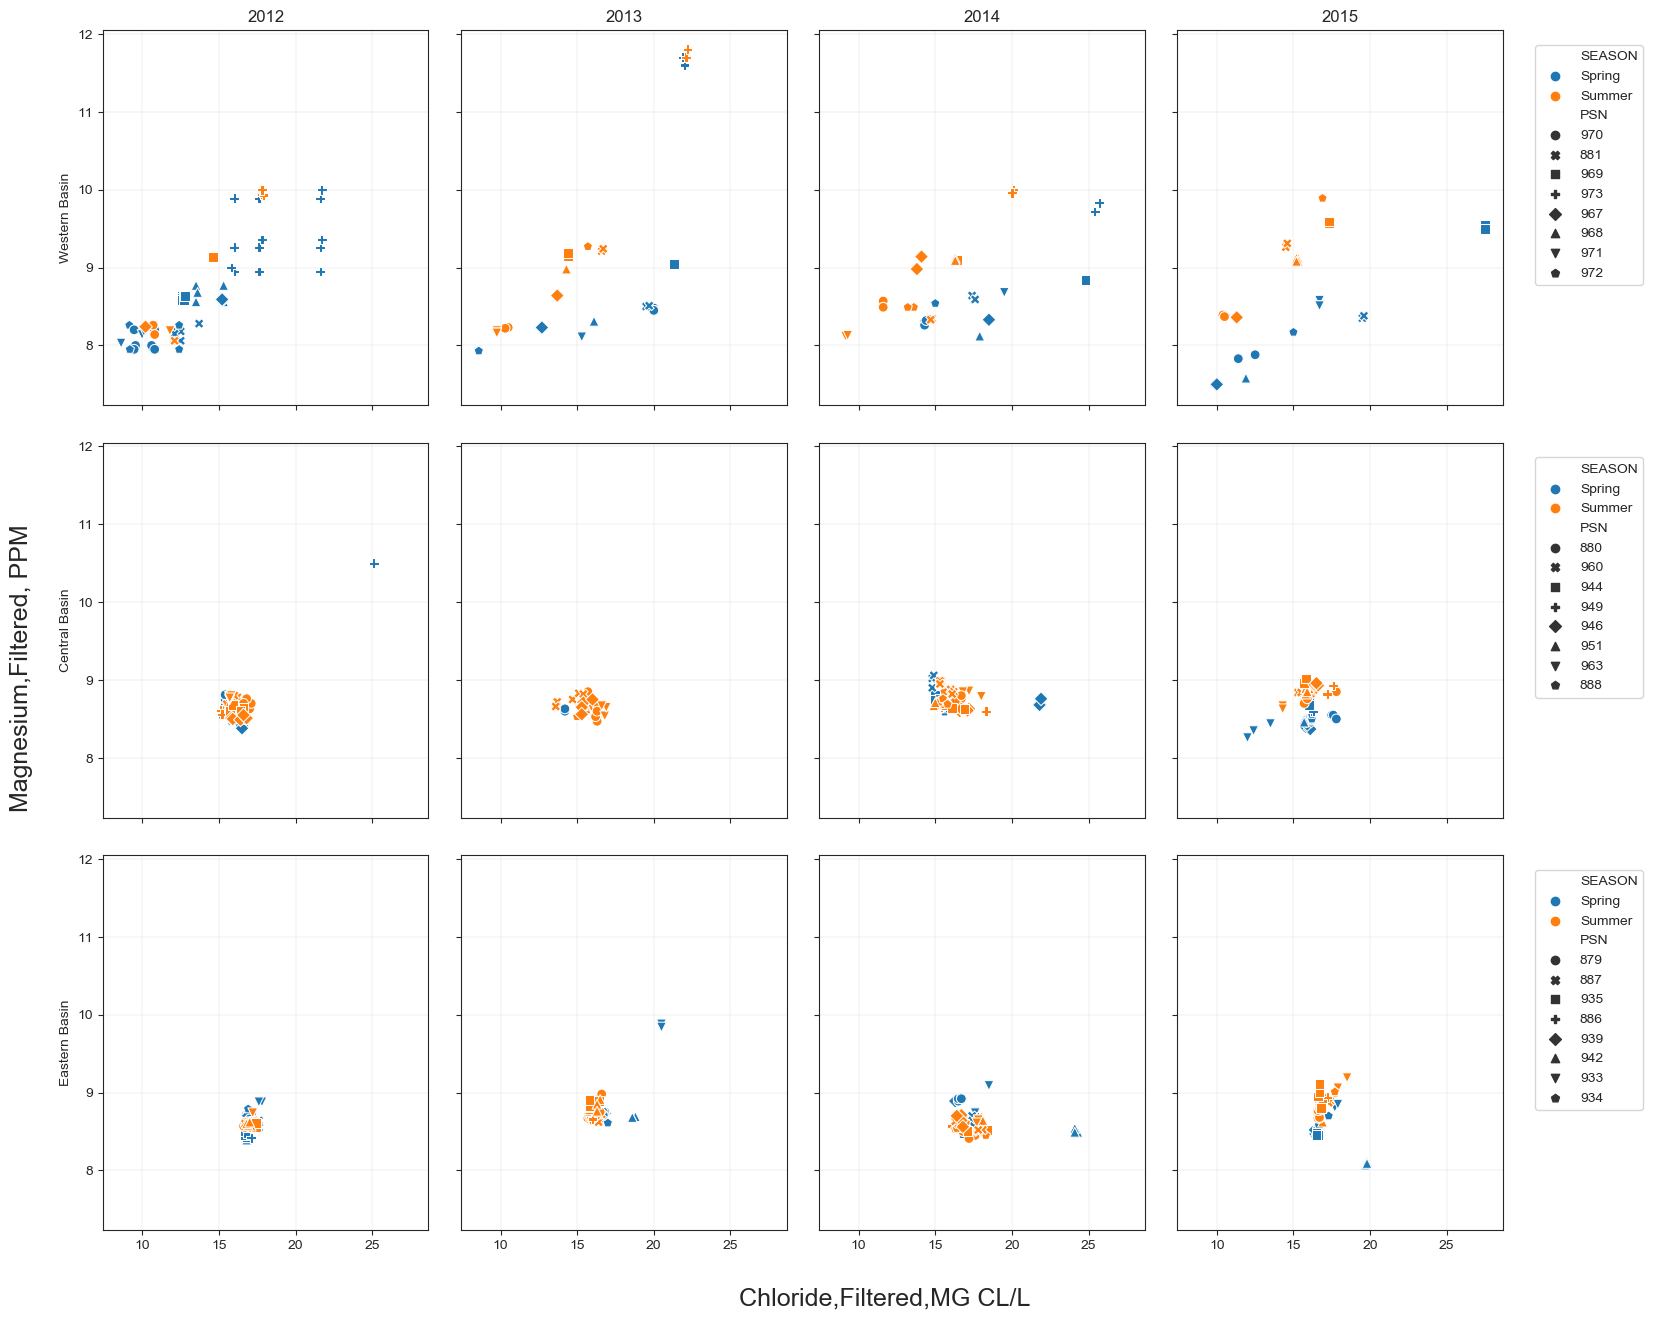

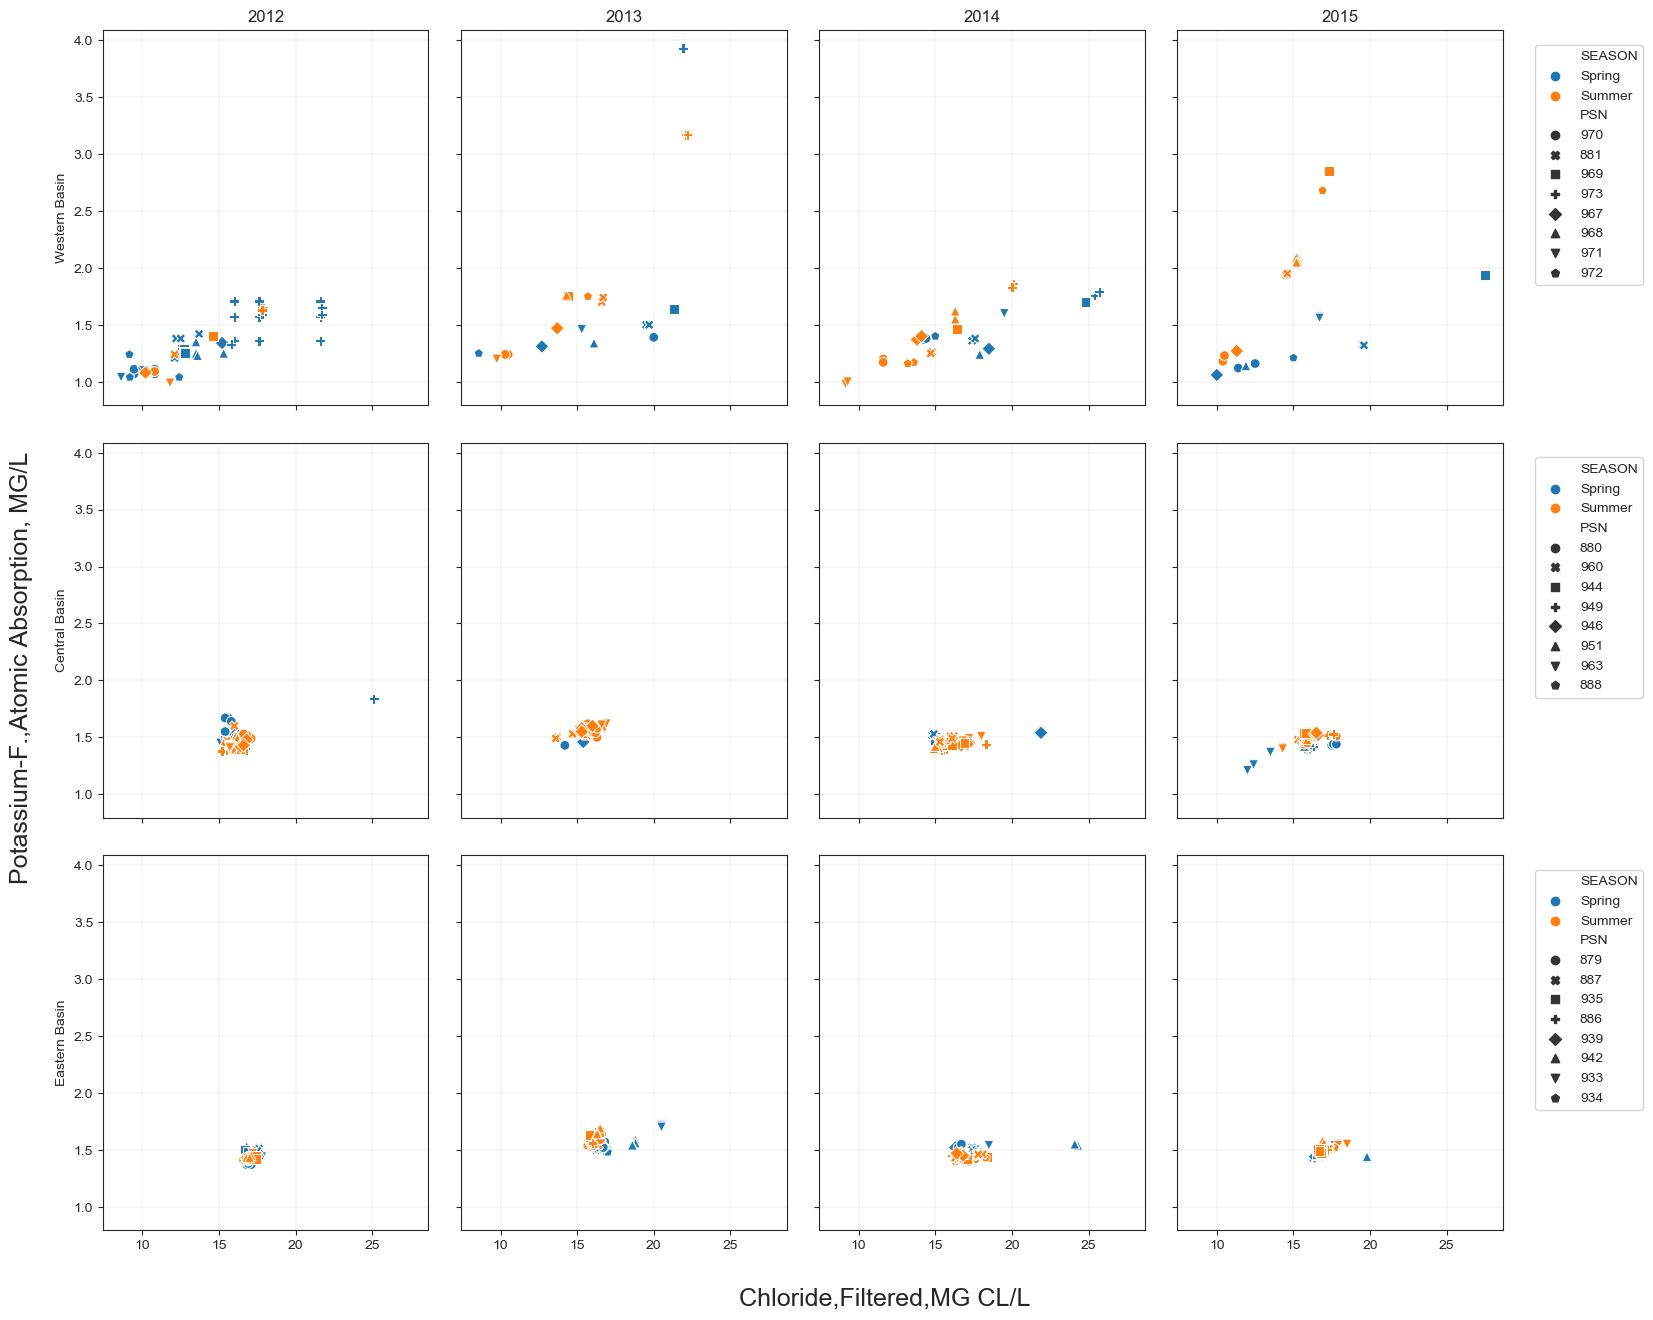

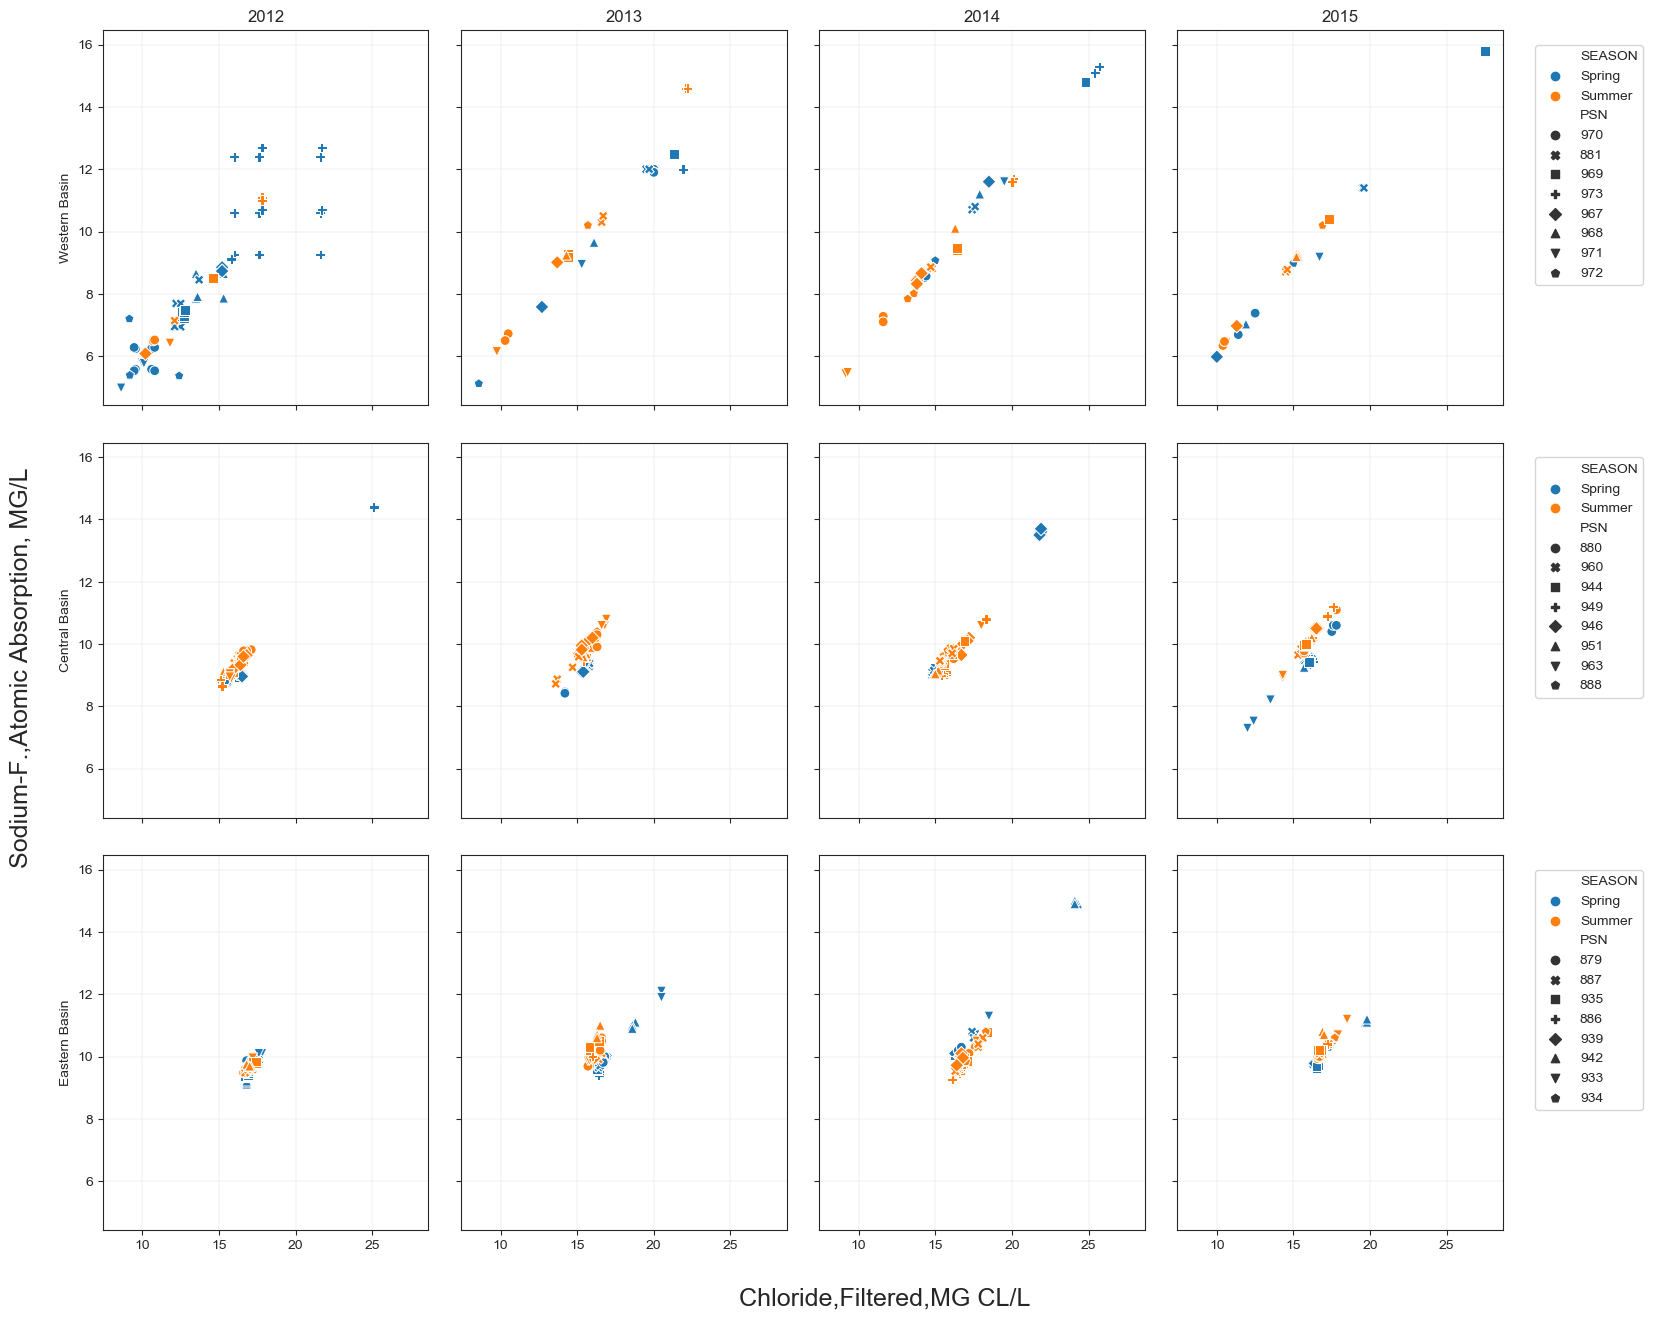

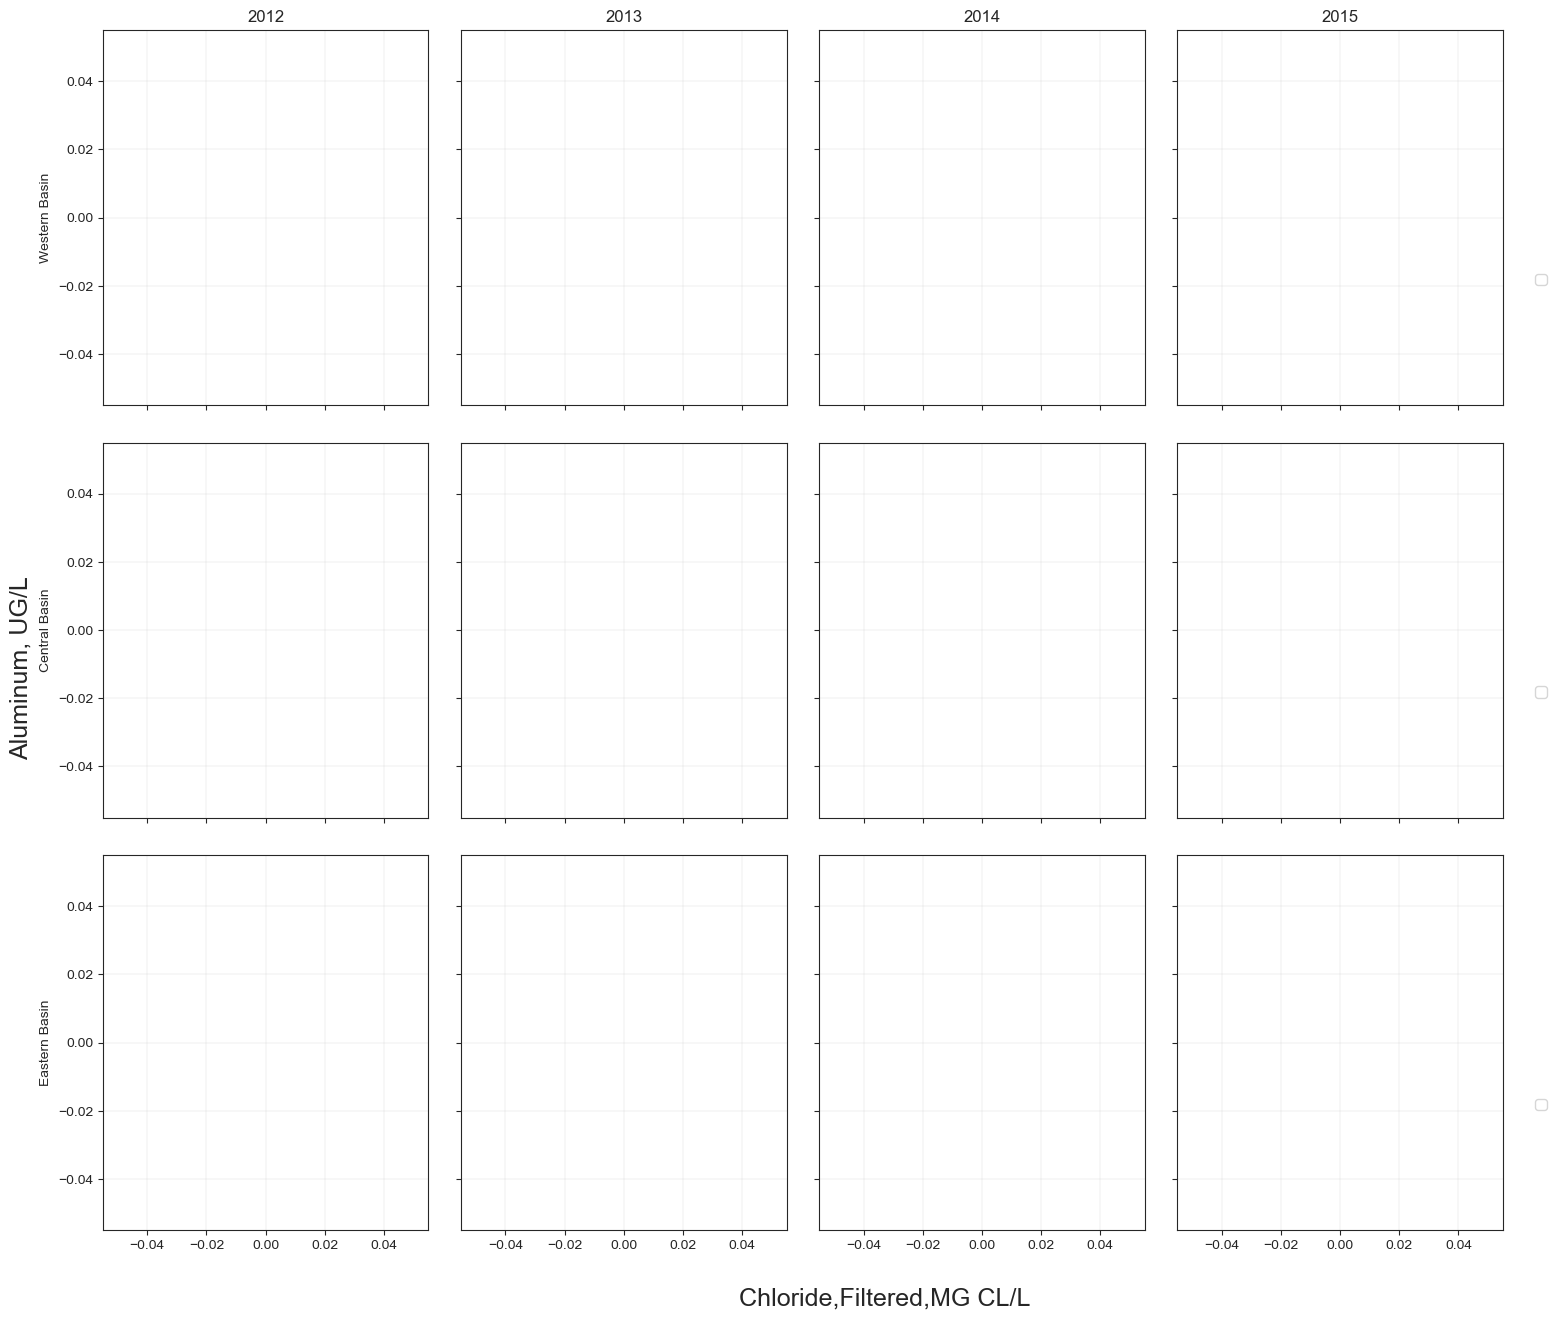

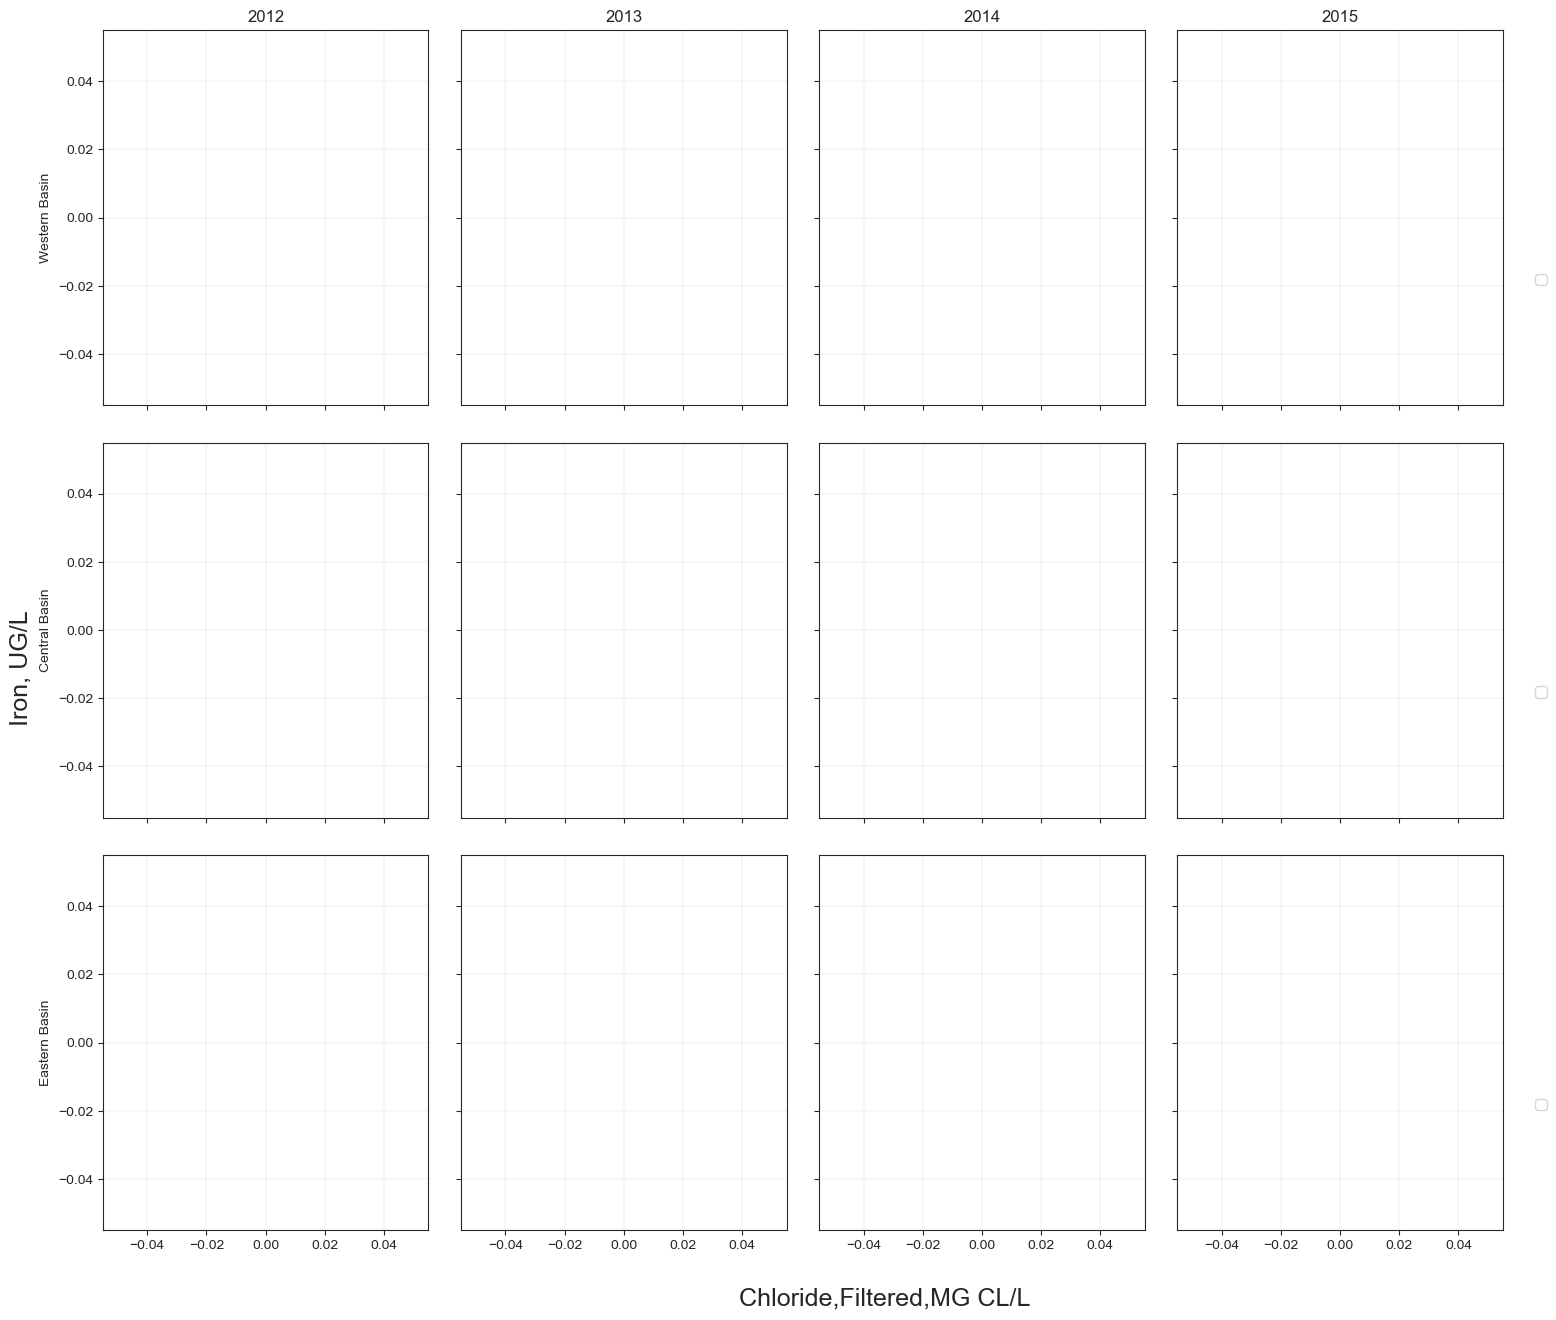

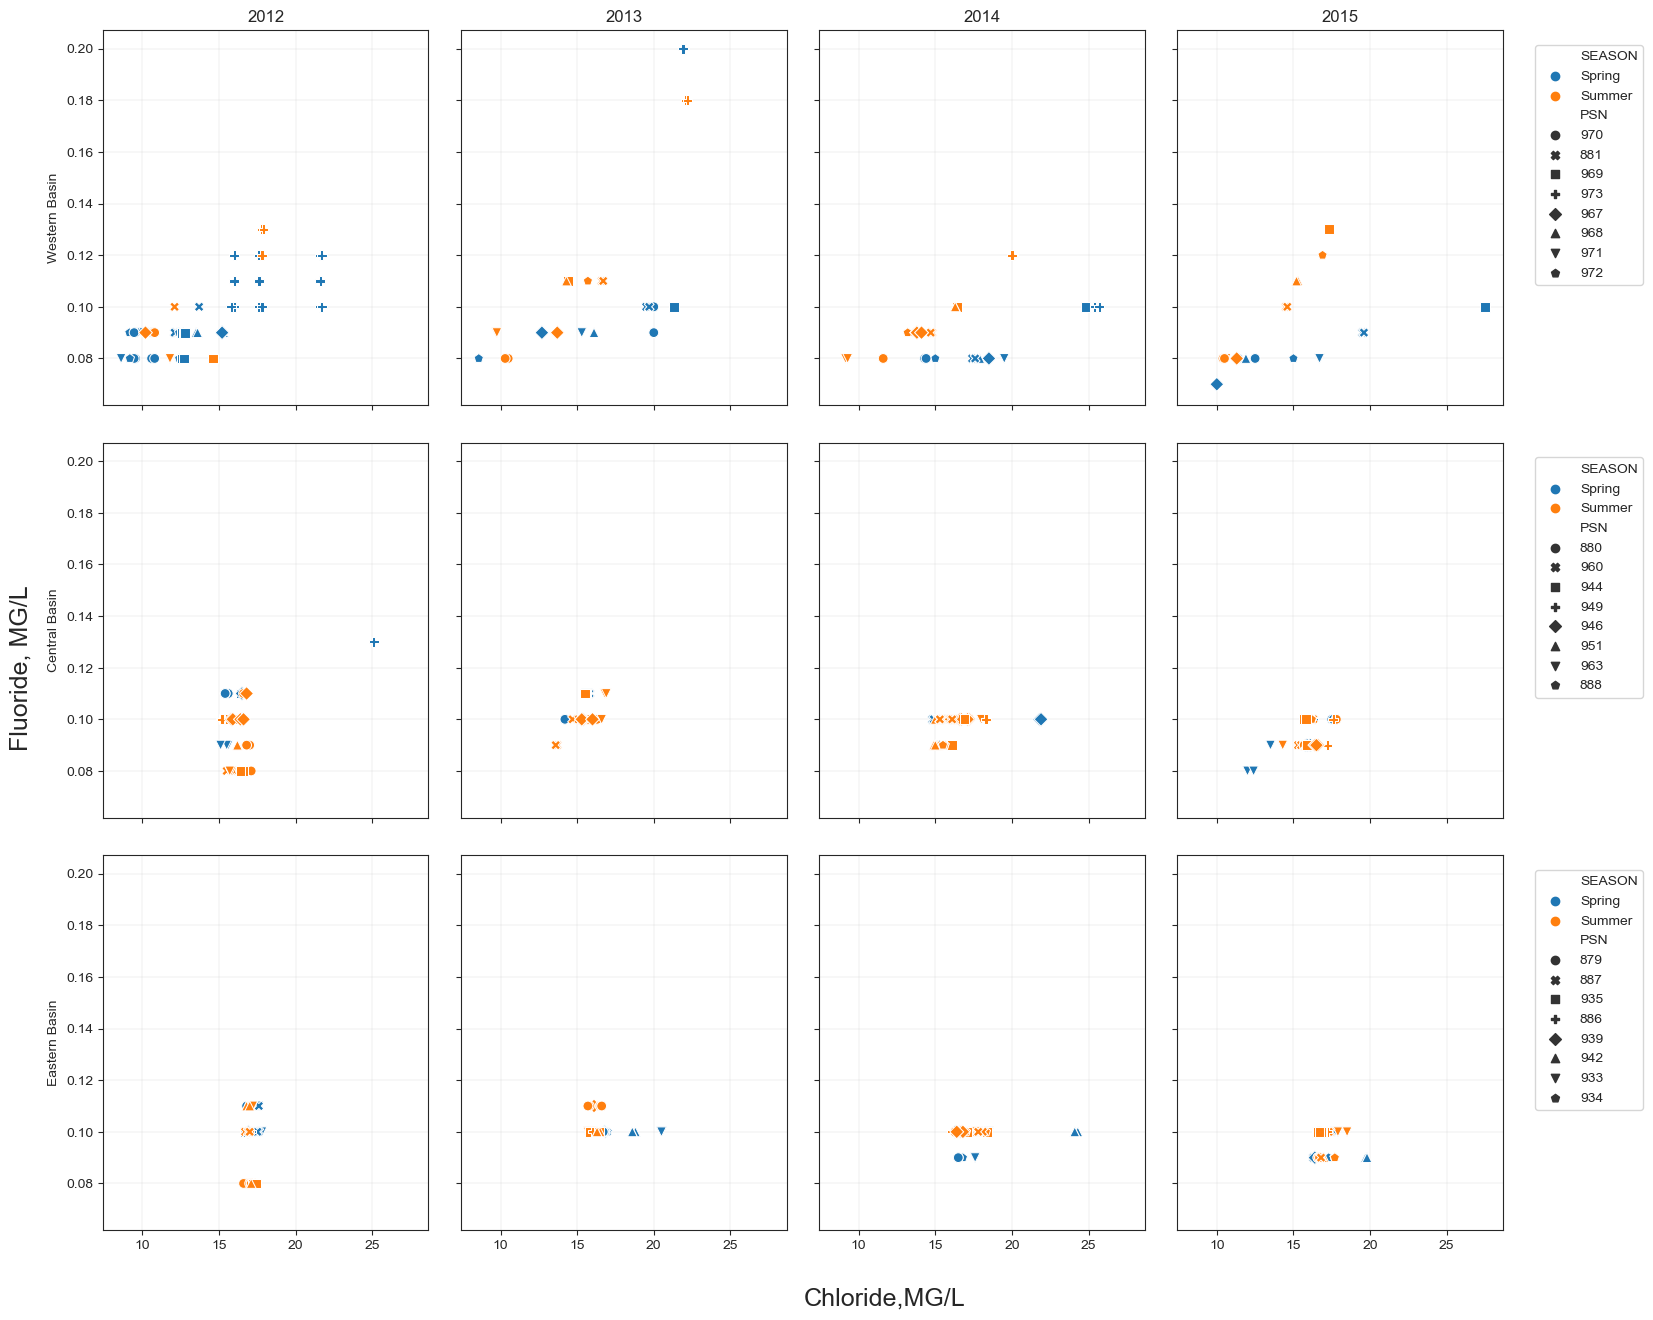

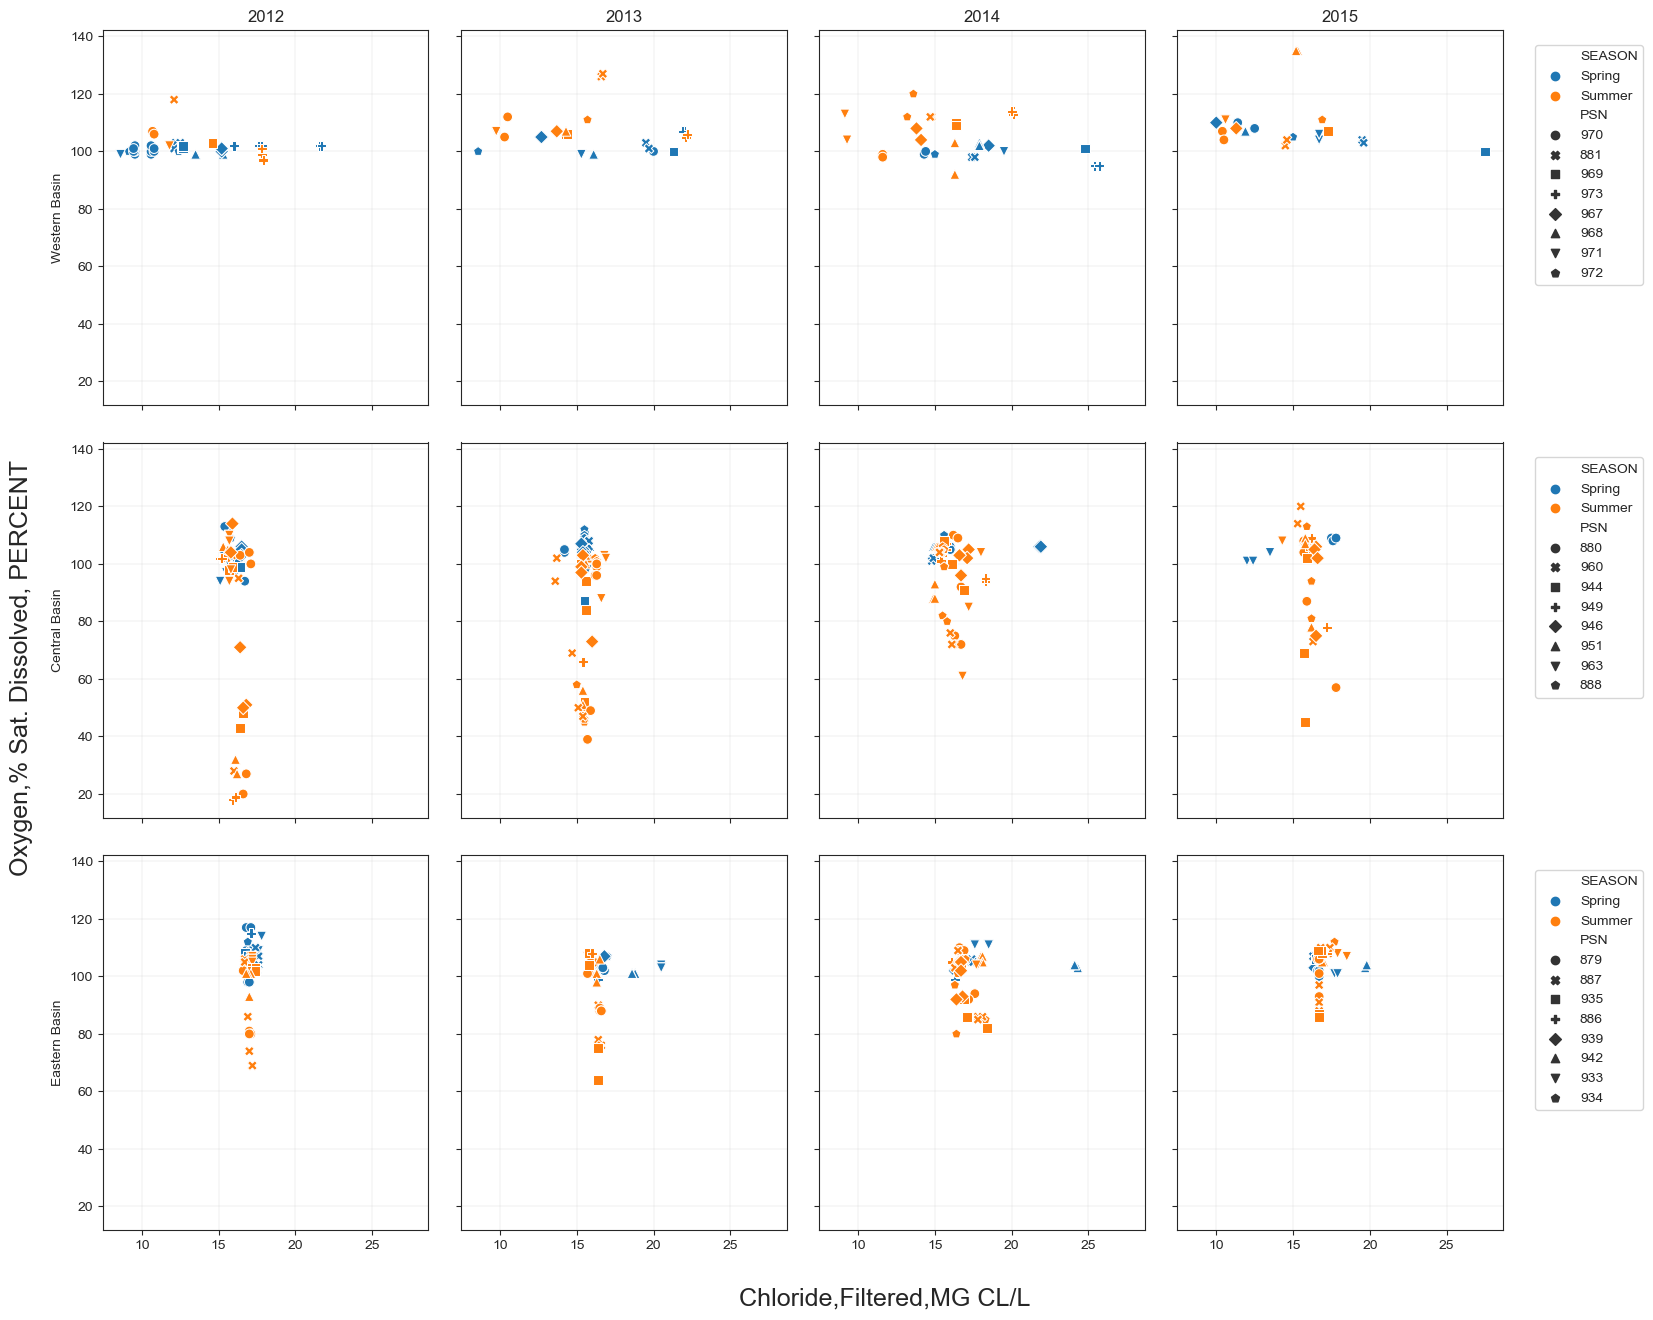

In [71]:
for a in combined_elements:#    a = ['TP-P-UF', 'TP']#ECCCmeas.ABBREV.unique():
    elem_1 = ECCCmeas[ECCCmeas.ABBREV.isin(a)]
    b = ['CL-F', 'CL F']#ECCCmeas.ABBREV.unique():
    elem_2 = ECCCmeas[ECCCmeas.ABBREV.isin(b)]
    Element = pd.merge(elem_1, elem_2, how='inner', on=['DEPTH_FROM', 'PSN', 'SEASON', 'YEAR'])
#     Element['VALUE'] = Element['VALUE_x']/Element['VALUE_y']*1000
    f, axes = plt.subplots(3,4, figsize=(5*4,5*3), dpi=100, sharex=True, sharey=True)
    for j, y in enumerate(years):
        for i, b in enumerate([western_basin_f[:8], central_basin_f[:8], eastern_basin_f[:8]]):

            sns_data = Element[(Element['PSN'].isin(b)) & (Element['YEAR']==y)]
    #         sns_data.loc[:,'VALUE'] *= 1000
    #         if a==['PH'] and y==2013:
            g=sns.scatterplot(x='VALUE_y', y='VALUE_x', data=sns_data, ax=axes[i][j], hue='SEASON', hue_order=seasons, style_order=b, style='PSN', s=50)
    #         sns.scatterplot(x='VALUE', y='DEPTH_FROM', data=sns_data, ax=axes[i][j], hue='SEASON', hue_order=seasons, style_order=b, style='PSN', s=50)


#             for k, s in enumerate(seasons):
#                 data = sns_data[sns_data['SEASON']==s]
#                 data = data.sort_values('DEPTH_FROM')
#                 xold = data.groupby('DEPTH_FROM').mean()['VALUE'].reset_index()['DEPTH_FROM'].values
#                 yold = data.groupby('DEPTH_FROM').mean()['VALUE'].reset_index()['VALUE'].values

#     #             tck,u  = interpolate.splprep([xold,yold], s=50000000000)
#     #             unew = np.arange(0, 1.00, 0.1)
    #             out = interpolate.splev(unew, tck)
#                 try:
#                     # lowess will return our "smoothed" data with a y value for at every x-value
#                     lowess = sm.nonparametric.lowess(yold, xold, frac=1)

#                     # unpack the lowess smoothed points to their values
#                     lowess_x = list(zip(*lowess))[0]
#                     lowess_y = list(zip(*lowess))[1]


#                     tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
#                     unew = np.arange(xold.min(), xold.max(), 1)
#                     out = tck(unew)

#                     if s=='Spring':
#                         clr=sns.color_palette().as_hex()[0]
#                     if s=='Summer' or s=='Fall':
#                         clr=sns.color_palette().as_hex()[1]
#         #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=Elementr, edgecolor='w')
        #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

#                     axes[i][j].plot(out, unew, c=clr, lw=2,zorder=1)
#                 except:
#                     pass
            axes[0][j].set_title(" ".join([str(y)]), fontsize='large')
#             axes[i][j].fill_betweenx(-data['z'], data['val']['mean']-data['val']['std'], data['val']['mean']+data['val']['std'], alpha=0.5, lw=0., color=Elementr)
#             axes[i][j].set_xlim(0,30)
#             axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            if y==2012:
                asns = g.get_legend_handles_labels()[0][:12]
                axes[i][j].legend(handles=asns, loc=(4.4,0.32))
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
    #                         axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
    #             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
    #                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')

    # asns = g.get_legend_handles_labels()[0][:12]

    # axes[0][3].legend(handles=asns, loc=(1,0))
    # axes[1][3].legend(handles=asns, loc=(1,0))
    # axes[2][3].legend(handles=asns, loc=(1,0))

    # axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

    # axes[2][2].set_xlim(16,18)
    # axes[2][0].set_xlim(16,17.5)

#     limits = []
#     for line in axes:
#         low = [min(a.get_ylim()[0], a.get_xlim()[0]) for a in line]
#         high = [max(a.get_xlim()[1], a.get_ylim()[1]) for a in line]
#         limits.append((min(low),max(high)))

#     for i,ax in enumerate(axes[0]):
#         axes[0][i].set_xlim(limits[0])
#         axes[0][i].set_ylim(limits[0])
#         axes[1][i].set_xlim(limits[1])
#         axes[1][i].set_ylim(limits[1])
#         axes[2][i].set_xlim(limits[2])
#         axes[2][i].set_ylim(limits[2])

#     axes[0][0].text(0.1,0.9, 'Western Basin', fontsize=18, horizontalalignment='left', transform=axes[0][0].transAxes)

    axes[0][0].set_ylabel('Western Basin')
    axes[1][0].set_ylabel('Central Basin')
    axes[2][0].set_ylabel('Eastern Basin')
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.9, wspace=0.1, hspace=0.1)
    # plt.tight_layout()
    try:
        axes[2][0].text(2.4,-0.2, Element.FULL_NAME_y.values[0].title().strip()+',' + Element.UNITS_y.values[0].strip() , fontsize=18, horizontalalignment='center', transform=axes[2][0].transAxes)
        axes[2][0].text(-0.25,1.5, Element.FULL_NAME_x.values[0].title().strip()+', '+  Element.UNITS_x.values[0].strip(), fontsize=18, verticalalignment='center', horizontalalignment='center', rotation=90, transform=axes[2][0].transAxes)
#         axes[2][0].text(2.4,-0.2, Element.FULL_NAME_x.values[0].title().strip()+' vs. '+Element.FULL_NAME_y.values[0].title().strip()+', [('+ Element.UNITS_x.values[0].strip()+') / ('+ Element.UNITS_y.values[0].strip() +')]', fontsize=14, horizontalalignment='center', transform=axes[2][0].transAxes)
        f.savefig('Mass Balance/GLENDA/All Stations/2012-2015/OneToOne/ECCC_'+Element.FULL_NAME_x.values[0].title().strip()+' vs. '+Element.FULL_NAME_y.values[0].title().strip()+'.pdf')
    except:
        pass



In [ ]:
elem_1.columns

In [ ]:
for a in combined_elements:#    a = ['TP-P-UF', 'TP']#ECCCmeas.ABBREV.unique():
    elem_1 = ECCCmeas[ECCCmeas.ABBREV.isin(a)]
    b = ['CL-F', 'CL F']#ECCCmeas.ABBREV.unique():
    elem_2 = ECCCmeas[ECCCmeas.ABBREV.isin(b)]
    Element = pd.merge(elem_1, elem_2, how='inner', on=['DEPTH_FROM', 'PSN', 'SEASON', 'YEAR'])
    Element['VALUE'] = Element['VALUE_x']/Element['VALUE_y']*1000
    f, axes = plt.subplots(3,4, figsize=(2.5*4,5*3), dpi=100, sharex=False, sharey=True)
    for j, y in enumerate(years):
        for i, b in enumerate([western_basin_f[:8], central_basin_f[:8], eastern_basin_f[:8]]):

            sns_data = Element[(Element['PSN'].isin(b)) & (Element['YEAR']==y)]
    #         sns_data.loc[:,'VALUE'] *= 1000
    #         if a==['PH'] and y==2013:
            g=sns.scatterplot(x='VALUE', y='DEPTH_FROM', data=sns_data, ax=axes[i][j], hue='SEASON', hue_order=seasons, style_order=b, style='PSN', s=50)
    #         sns.scatterplot(x='VALUE', y='DEPTH_FROM', data=sns_data, ax=axes[i][j], hue='SEASON', hue_order=seasons, style_order=b, style='PSN', s=50)


            for k, s in enumerate(seasons):
                data = sns_data[sns_data['SEASON']==s]
                data = data.sort_values('DEPTH_FROM')
                xold = data.groupby('DEPTH_FROM').mean()['VALUE'].reset_index()['DEPTH_FROM'].values
                yold = data.groupby('DEPTH_FROM').mean()['VALUE'].reset_index()['VALUE'].values

    #             tck,u  = interpolate.splprep([xold,yold], s=50000000000)
    #             unew = np.arange(0, 1.00, 0.1)
    #             out = interpolate.splev(unew, tck)
                try:
                    # lowess will return our "smoothed" data with a y value for at every x-value
                    lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                    # unpack the lowess smoothed points to their values
                    lowess_x = list(zip(*lowess))[0]
                    lowess_y = list(zip(*lowess))[1]


                    tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                    unew = np.arange(xold.min(), xold.max(), 1)
                    out = tck(unew)

                    if s=='Spring':
                        clr=sns.color_palette().as_hex()[0]
                    if s=='Summer' or s=='Fall':
                        clr=sns.color_palette().as_hex()[1]
        #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=Elementr, edgecolor='w')
        #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                    axes[i][j].plot(out, unew, c=clr, lw=2,zorder=1)
                except:
                    pass
                axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
    #             axes[i][j].fill_betweenx(-data['z'], data['val']['mean']-data['val']['std'], data['val']['mean']+data['val']['std'], alpha=0.5, lw=0., color=Elementr)
    #             axes[i][j].set_xlim(0,30)
                axes[i][j].set_ylim(-64,0)
                axes[i][j].grid(lw=0.2)
                axes[i][j].legend()
                axes[i][j].legend_.remove()
                if y==2012:
                    asns = g.get_legend_handles_labels()[0][:12]
                    axes[i][j].legend(handles=asns, loc=(4.7,0.32))
                axes[i][j].set_xlabel('')
                axes[i][j].set_ylabel('')
    #                         axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
    #             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
    #                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')

    # asns = g.get_legend_handles_labels()[0][:12]

    # axes[0][3].legend(handles=asns, loc=(1,0))
    # axes[1][3].legend(handles=asns, loc=(1,0))
    # axes[2][3].legend(handles=asns, loc=(1,0))

    # axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

    # axes[2][2].set_xlim(16,18)
    # axes[2][0].set_xlim(16,17.5)

    limits = []
    for line in axes:
        low = [a.get_xlim()[0] for a in line]
        high = [a.get_xlim()[1] for a in line]
        limits.append((min(low),max(high)))

    for i,ax in enumerate(axes[0]):
        axes[0][i].set_xlim(limits[0])
        axes[1][i].set_xlim(limits[1])
        axes[2][i].set_xlim(limits[2])



    axes[0][0].set_ylabel('Depth, [m]')
    axes[1][0].set_ylabel('Depth, [m]')
    axes[2][0].set_ylabel('Depth, [m]')
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.9)
    # plt.tight_layout()
    try:
        axes[2][0].text(2.4,-0.2, Element.FULL_NAME_x.values[0].title().strip()+' vs. '+Element.FULL_NAME_y.values[0].title().strip()+', [$\mu g$ $mg^{-1}$]', fontsize=14, horizontalalignment='center', transform=axes[2][0].transAxes)
#         axes[2][0].text(2.4,-0.2, Element.FULL_NAME_x.values[0].title().strip()+' vs. '+Element.FULL_NAME_y.values[0].title().strip()+', [('+ Element.UNITS_x.values[0].strip()+') / ('+ Element.UNITS_y.values[0].strip() +')]', fontsize=14, horizontalalignment='center', transform=axes[2][0].transAxes)
        f.savefig('Mass Balance/GLENDA/All Stations/2012-2015/ECCC/'+Element.FULL_NAME_x.values[0].title().strip()+' vs. '+Element.FULL_NAME_y.values[0].title().strip()+'.pdf')
    except:
        pass



In [ ]:
ECCCmeas.ABBREV.unique()

In [ ]:
for a in combined_elements:#ECCCmeas.ABBREV.unique():
    elem_1 = ECCCmeas[ECCCmeas.ABBREV.isin(a)]
    for b in combined_elements:#ECCCmeas.ABBREV.unique():
        if a==b:
            pass
        else:
            elem_2 = ECCCmeas[ECCCmeas.ABBREV.isin(b)]
            Element = pd.merge(elem_1, elem_2, how='inner', on=['DEPTH_FROM', 'PSN', 'SEASON', 'YEAR'])
            Element['VALUE'] = Element['VALUE_x']/Element['VALUE_y']
            f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
            for j, y in enumerate(years):
                for i, b in enumerate([western_basin_f[:8], central_basin_f[:8], eastern_basin_f[:8]]):

                    sns_data = Element[(Element['PSN'].isin(b)) & (Element['YEAR']==y)]
                    if a==['PH'] and y==2013:
                        g=sns.scatterplot(x='VALUE', y='DEPTH_FROM', data=sns_data, ax=axes[i][j], hue='SEASON', hue_order=seasons, style_order=b, style='PSN', s=50)
                    sns.scatterplot(x='VALUE', y='DEPTH_FROM', data=sns_data, ax=axes[i][j], hue='SEASON', hue_order=seasons, style_order=b, style='PSN', s=50)


                    for k, s in enumerate(seasons):
                        data = sns_data[sns_data['SEASON']==s]
                        data = data.sort_values('DEPTH_FROM')
                        xold = data.groupby('DEPTH_FROM').mean()['VALUE'].reset_index()['DEPTH_FROM'].values
                        yold = data.groupby('DEPTH_FROM').mean()['VALUE'].reset_index()['VALUE'].values

            #             tck,u  = interpolate.splprep([xold,yold], s=50000000000)
            #             unew = np.arange(0, 1.00, 0.1)
            #             out = interpolate.splev(unew, tck)
                        try:
                            # lowess will return our "smoothed" data with a y value for at every x-value
                            lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                            # unpack the lowess smoothed points to their values
                            lowess_x = list(zip(*lowess))[0]
                            lowess_y = list(zip(*lowess))[1]


                            tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                            unew = np.arange(xold.min(), xold.max(), 1)
                            out = tck(unew)

                            if s=='Spring':
                                clr=sns.color_palette().as_hex()[0]
                            if s=='Summer' or s=='Fall':
                                clr=sns.color_palette().as_hex()[1]
                #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=Elementr, edgecolor='w')
                #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                            axes[i][j].plot(out, unew, c=clr, lw=2,zorder=1)
                        except:
                            pass
                        axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            #             axes[i][j].fill_betweenx(-data['z'], data['val']['mean']-data['val']['std'], data['val']['mean']+data['val']['std'], alpha=0.5, lw=0., color=Elementr)
            #             axes[i][j].set_xlim(0,30)
                        axes[i][j].set_ylim(-64,0)
                        axes[i][j].grid(lw=0.2)
                        axes[i][j].legend()
                        axes[i][j].legend_.remove()
                        axes[i][j].set_xlabel('')
                        axes[i][j].set_ylabel('')
#                         axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
            #             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
            #                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')

            asns = g.get_legend_handles_labels()[0][:12]

            axes[0][12].legend(handles=asns, loc=(3.5,0))
            axes[1][12].legend(handles=asns, loc=(3.5,0))
            axes[2][12].legend(handles=asns, loc=(3.5,0))

            # axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

            # axes[2][2].set_xlim(16,18)
            # axes[2][0].set_xlim(16,17.5)

            limits = []
            for line in axes:
                low = [a.get_xlim()[0] for a in line]
                high = [a.get_xlim()[1] for a in line]
                limits.append((min(low),max(high)))

            #     for i,ax in enumerate(axes[0]):
            #         axes[0][i].set_xlim(limits[0])
            #         axes[1][i].set_xlim(limits[1])
            #         axes[2][i].set_xlim(limits[2])



            axes[0][0].set_ylabel('Depth, [m]')
            axes[1][0].set_ylabel('Depth, [m]')
            axes[2][0].set_ylabel('Depth, [m]')
            try:
                axes[2][0].text(8.5,-0.2, Element.FULL_NAME_x.values[0].title().strip()+' vs. '+Element.FULL_NAME_y.values[0].title().strip()+', ['+ Element.UNITS_x.values[0].strip()+' vs. '+ Element.UNITS_y.values[0].strip() +']', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
                f.savefig('Mass Balance/GLENDA/All Stations/ECCC Ratios/'+Element.FULL_NAME_y.values[0].strip()+'/'+Element.FULL_NAME_x.values[0].title().strip()+' vs. '+Element.FULL_NAME_y.values[0].title().strip()+'_no_scales.pdf')
            except:
                pass



In [ ]:
elem_1 = ECCCmeas[ECCCmeas.ABBREV==a]

In [ ]:
elem_2 = ECCCmeas[ECCCmeas.ABBREV==b]

In [ ]:
Ratios = pd.merge(elem_1, elem_2, how='inner', on=['DEPTH_FROM', 'PSN', 'SEASON', 'YEAR'])
Ratios['VALUE'] = Ratios['VALUE_x']/Ratios['VALUE_y']


In [ ]:
Ratios['VALUE'] = Ratios['VALUE_x']/Ratios['VALUE_y']

In [ ]:
Ratios.shape

In [ ]:
elem_1.shape

In [ ]:
import os
for directory in ECCCmeas.FULL_NAME.unique():
    directory = directory.strip()
    if not os.path.exists('/Users/imarkelo/git/Great-Lakes-Data/post_proc_scripts/Mass Balance/Mass Balance/GLENDA/All Stations/ECCC Ratios/'+directory):
        os.makedirs('/Users/imarkelo/git/Great-Lakes-Data/post_proc_scripts/Mass Balance/Mass Balance/GLENDA/All Stations/ECCC Ratios/'+directory)